In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
import os
!pip install openpyxl tensorflow
import openpyxl

# --- Bloc 1: Paramètres Globaux et Fonctions Utilitaires ---
SAMPLING_RATE = 50
DT = 1.0 / SAMPLING_RATE
CHARGE_KG = 15
FORCE_DUE_A_LA_CHARGE = CHARGE_KG * 9.81
G_ACCEL = 9.81

NOISE_STD_ACC_BASE = 0.50
NOISE_STD_GYRO_BASE = 0.08
NOISE_STD_FORCE_BASE = 4.5

BASE_DUREE_CLIC_BOUTON_AVG = 0.15
RAND_FACTOR_CLIC = 0.8

BASE_DUREE_REDRESSEMENT_CHARGE = 1.5
BASE_DUREE_ROTATION = 1.5
BASE_DUREE_MARCHE_AVEC_CHARGE = 4.0
BASE_DUREE_FLEXION_POSE = 1.2
BASE_DUREE_AVANT_CLIC_DEBLOCAGE = 0.25
BASE_DUREE_REDRESSEMENT_SANS_CHARGE = 1.2
BASE_DUREE_POST_FINAL = 2.5

SUM_BASE_CORE_DURATIONS_TRAINING = (BASE_DUREE_CLIC_BOUTON_AVG * 2) + \
                                   BASE_DUREE_REDRESSEMENT_CHARGE + \
                                   BASE_DUREE_ROTATION + \
                                   BASE_DUREE_MARCHE_AVEC_CHARGE + \
                                   BASE_DUREE_FLEXION_POSE + \
                                   BASE_DUREE_AVANT_CLIC_DEBLOCAGE + \
                                   BASE_DUREE_REDRESSEMENT_SANS_CHARGE

SUM_BASE_CORE_DURATIONS_INFERENCE = BASE_DUREE_CLIC_BOUTON_AVG + \
                                    BASE_DUREE_REDRESSEMENT_CHARGE + \
                                    BASE_DUREE_ROTATION + \
                                    BASE_DUREE_MARCHE_AVEC_CHARGE + \
                                    BASE_DUREE_FLEXION_POSE

DELTA_HAUTEUR_REDRESSEMENT1 = 0.7
ANGLE_ROTATION_YAW = np.deg2rad(90)
DISTANCE_MARCHE = 2.0
DELTA_HAUTEUR_FLEXION_POSE = -0.3
ANGLE_FLEXION_PITCH_POSE = np.deg2rad(25)
# La variable globale angle_redressement_pitch_final = -ANGLE_FLEXION_PITCH_POSE est correcte ici si Bloc 1 est exécuté

INITIAL_POS_X = 0.0
INITIAL_POS_Y = 0.0
INITIAL_POS_Z = 0.5
INITIAL_ANGLE_ROLL = 0.0
INITIAL_ANGLE_PITCH = np.deg2rad(15)
INITIAL_ANGLE_YAW = 0.0

MIN_TARGET_TOTAL_DURATION = 7.0
MAX_TARGET_TOTAL_DURATION = 11.0
PHASE_VAR_FACTOR = 0.1

def generate_pulse(data_array, total_samples_local, start_time, end_time, amplitude):
    start_idx = max(0, int(start_time * SAMPLING_RATE))
    end_idx = min(total_samples_local, int(end_time * SAMPLING_RATE))
    if start_idx < end_idx:
        data_array[start_idx:end_idx] = amplitude
    return data_array

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def generate_sigmoid_ramp(data_array, total_samples_local, start_time, end_time, start_value, end_value, k=8):
    start_idx = max(0, int(start_time * SAMPLING_RATE))
    end_idx = min(total_samples_local, int(end_time * SAMPLING_RATE))
    if start_idx < end_idx:
        duration_points = end_idx - start_idx
        if duration_points == 0: return data_array
        x_lin = np.linspace(-k/2, k/2, duration_points)
        scaled_sigmoid = sigmoid(x_lin)
        data_array[start_idx:end_idx] = start_value + (end_value - start_value) * scaled_sigmoid
    return data_array

def apply_acceleration_for_displacement(acc_axis_data, total_samples_local, start_time, end_time, displacement, is_z_axis=False):
    start_idx = max(0, int(start_time * SAMPLING_RATE))
    end_idx = min(total_samples_local, int(end_time * SAMPLING_RATE))
    duration_total_move = end_time - start_time

    if duration_total_move <= DT or start_idx >= end_idx:
        return acc_axis_data

    V_peak = (2 * displacement) / duration_total_move
    mid_time = start_time + duration_total_move / 2
    mid_idx = max(start_idx, min(end_idx -1, int(mid_time * SAMPLING_RATE)))

    duration_phase1 = mid_time - start_time
    current_phase_end_idx = mid_idx
    if duration_phase1 > DT/2 and start_idx < current_phase_end_idx :
        amplitude_acc1 = (2 * V_peak) / duration_phase1
        num_points_phase1 = current_phase_end_idx - start_idx
        if num_points_phase1 == 0 : return acc_axis_data
        t_pulse1 = np.linspace(0, duration_phase1, num_points_phase1, endpoint=False)
        acc_pulse1 = (amplitude_acc1 / 2) * (1 - np.cos(2 * np.pi * t_pulse1 / duration_phase1))
        if is_z_axis:
            acc_axis_data[start_idx:current_phase_end_idx] += acc_pulse1
        else:
            acc_axis_data[start_idx:current_phase_end_idx] = acc_pulse1

    duration_phase2 = end_time - mid_time
    current_phase_start_idx = mid_idx
    if duration_phase2 > DT/2 and current_phase_start_idx < end_idx:
        amplitude_acc2 = (2 * -V_peak) / duration_phase2
        num_points_phase2 = end_idx - current_phase_start_idx
        if num_points_phase2 == 0 : return acc_axis_data
        t_pulse2 = np.linspace(0, duration_phase2, num_points_phase2, endpoint=False)
        acc_pulse2 = (amplitude_acc2 / 2) * (1 - np.cos(2 * np.pi * t_pulse2 / duration_phase2))
        if is_z_axis:
            acc_axis_data[current_phase_start_idx:end_idx] += acc_pulse2
        else:
            acc_axis_data[current_phase_start_idx:end_idx] = acc_pulse2
    return acc_axis_data

def apply_angular_velocity_for_rotation(gyro_axis_data, total_samples_local, start_time, end_time, total_angle_change):
    start_idx = max(0, int(start_time * SAMPLING_RATE))
    end_idx = min(total_samples_local, int(end_time * SAMPLING_RATE))
    duration_pulse = end_time - start_time

    if duration_pulse <= DT or start_idx >= end_idx:
        return gyro_axis_data

    amplitude_omega_pulse = (2 * total_angle_change) / duration_pulse
    num_points_pulse = end_idx - start_idx
    if num_points_pulse == 0: return gyro_axis_data
    t_pulse_overall = np.linspace(0, duration_pulse, num_points_pulse, endpoint=False)
    gyro_pulse_overall = (amplitude_omega_pulse / 2) * (1 - np.cos(2 * np.pi * t_pulse_overall / duration_pulse))
    gyro_axis_data[start_idx:end_idx] = gyro_pulse_overall
    return gyro_axis_data

# --- Bloc 2: Fonction de Génération pour une Simulation ---
def generate_single_simulation_data(simulation_id, generation_mode="training"):
    """Génère les données pour une seule simulation avec variabilité temporelle et bruit."""
    print(f"Génération de la simulation {simulation_id} (Mode: {generation_mode})...")

    target_total_duration_sim = np.random.uniform(MIN_TARGET_TOTAL_DURATION, MAX_TARGET_TOTAL_DURATION)

    sum_base_durations_for_mode = SUM_BASE_CORE_DURATIONS_TRAINING if generation_mode == "training" else SUM_BASE_CORE_DURATIONS_INFERENCE

    target_core_actions_duration = target_total_duration_sim - BASE_DUREE_POST_FINAL
    min_core_actions_duration = sum_base_durations_for_mode * 0.7
    target_core_actions_duration = max(min_core_actions_duration, target_core_actions_duration)

    core_action_scaling_factor = target_core_actions_duration / sum_base_durations_for_mode

    def get_noisy_duration(base_duration, min_duration=0.05):
        scaled_duration = base_duration * core_action_scaling_factor
        noisy_duration = scaled_duration * (1 + np.random.uniform(-PHASE_VAR_FACTOR, PHASE_VAR_FACTOR))
        return max(min_duration, noisy_duration)

    duree_clic_bouton1_noisy = max(0.05, BASE_DUREE_CLIC_BOUTON_AVG * (1 + np.random.uniform(-RAND_FACTOR_CLIC, RAND_FACTOR_CLIC)))
    duree_redressement_charge = get_noisy_duration(BASE_DUREE_REDRESSEMENT_CHARGE, 0.5)
    duree_rotation = get_noisy_duration(BASE_DUREE_ROTATION, 0.5)
    duree_marche_avec_charge = get_noisy_duration(BASE_DUREE_MARCHE_AVEC_CHARGE, 2.0)
    duree_flexion_pose = get_noisy_duration(BASE_DUREE_FLEXION_POSE, 0.5)

    t_appui_bouton_blocage = 0.0
    t_fin_appui_blocage = t_appui_bouton_blocage + duree_clic_bouton1_noisy
    t_debut_redressement_charge = t_fin_appui_blocage
    t_fin_redressement_charge = t_debut_redressement_charge + duree_redressement_charge
    t_debut_deplacement_global = t_fin_redressement_charge
    t_fin_deplacement_global = t_debut_deplacement_global + duree_rotation + duree_marche_avec_charge
    t_debut_flexion_pose = t_fin_deplacement_global
    t_fin_flexion_pose = t_debut_flexion_pose + duree_flexion_pose
    t_charge_totalement_posee = t_fin_flexion_pose

    # CORRECTION: Définir angle_redressement_pitch_final ici pour qu'il soit dans la portée
    # en se basant sur la constante globale ANGLE_FLEXION_PITCH_POSE.
    # Cela ne change pas la logique, mais assure que la variable est définie.
    local_angle_redressement_pitch_final = -ANGLE_FLEXION_PITCH_POSE

    if generation_mode == "training":
        duree_avant_clic_deblocage = get_noisy_duration(BASE_DUREE_AVANT_CLIC_DEBLOCAGE, 0.1)
        duree_clic_bouton2_noisy = max(0.05, BASE_DUREE_CLIC_BOUTON_AVG * (1 + np.random.uniform(-RAND_FACTOR_CLIC, RAND_FACTOR_CLIC)))
        duree_redressement_sans_charge = get_noisy_duration(BASE_DUREE_REDRESSEMENT_SANS_CHARGE, 0.5)

        t_appui_bouton_deblocage = t_charge_totalement_posee + duree_avant_clic_deblocage
        t_fin_appui_deblocage = t_appui_bouton_deblocage + duree_clic_bouton2_noisy
        t_debut_redressement_sans_charge = t_fin_appui_deblocage
        t_fin_redressement_sans_charge = t_debut_redressement_sans_charge + duree_redressement_sans_charge
        duration_sim = t_fin_redressement_sans_charge + BASE_DUREE_POST_FINAL
    else:
        duree_clic_bouton2_noisy = 0
        t_appui_bouton_deblocage = t_charge_totalement_posee
        t_fin_appui_deblocage = t_appui_bouton_deblocage
        t_debut_redressement_sans_charge = t_fin_appui_deblocage
        t_fin_redressement_sans_charge = t_debut_redressement_sans_charge
        duration_sim = t_charge_totalement_posee + BASE_DUREE_POST_FINAL

    total_samples_sim = int(SAMPLING_RATE * duration_sim)
    time_vector_sim = np.linspace(0, duration_sim, total_samples_sim, endpoint=False)

    acc_x_c = np.zeros(total_samples_sim)
    acc_y_c = np.zeros(total_samples_sim)
    acc_z_c = np.full(total_samples_sim, G_ACCEL)
    gyro_x_c = np.zeros(total_samples_sim)
    gyro_y_c = np.zeros(total_samples_sim)
    gyro_z_c = np.zeros(total_samples_sim)
    force1_c = np.zeros(total_samples_sim)
    force2_c = np.zeros(total_samples_sim)
    btn_state_sim = np.zeros(total_samples_sim)

    btn_state_sim = generate_pulse(btn_state_sim, total_samples_sim, t_appui_bouton_blocage, t_fin_appui_blocage, 1)
    if generation_mode == "training":
        btn_state_sim = generate_pulse(btn_state_sim, total_samples_sim, t_appui_bouton_deblocage, t_fin_appui_deblocage, 1)

    duree_montee_force_sim = max(0.15, 0.3 * core_action_scaling_factor * (1 + np.random.uniform(-0.1, 0.1)))
    force1_c = generate_sigmoid_ramp(force1_c, total_samples_sim, t_fin_appui_blocage, t_fin_appui_blocage + duree_montee_force_sim, 0, FORCE_DUE_A_LA_CHARGE / 2)
    force2_c = generate_sigmoid_ramp(force2_c, total_samples_sim, t_fin_appui_blocage, t_fin_appui_blocage + duree_montee_force_sim, 0, FORCE_DUE_A_LA_CHARGE / 2)
    idx_maintien_s = int((t_fin_appui_blocage + duree_montee_force_sim) * SAMPLING_RATE)
    idx_maintien_e = int(t_debut_flexion_pose * SAMPLING_RATE)
    if idx_maintien_s < idx_maintien_e:
        force1_c = generate_pulse(force1_c, total_samples_sim, (t_fin_appui_blocage + duree_montee_force_sim), t_debut_flexion_pose, FORCE_DUE_A_LA_CHARGE / 2)
        force2_c = generate_pulse(force2_c, total_samples_sim, (t_fin_appui_blocage + duree_montee_force_sim), t_debut_flexion_pose, FORCE_DUE_A_LA_CHARGE / 2)
    force1_c = generate_sigmoid_ramp(force1_c, total_samples_sim, t_debut_flexion_pose, t_charge_totalement_posee, FORCE_DUE_A_LA_CHARGE / 2, 0)
    force2_c = generate_sigmoid_ramp(force2_c, total_samples_sim, t_debut_flexion_pose, t_charge_totalement_posee, FORCE_DUE_A_LA_CHARGE / 2, 0)
    idx_fn = int(t_charge_totalement_posee * SAMPLING_RATE)
    if idx_fn < total_samples_sim:
        force1_c[idx_fn:] = 0
        force2_c[idx_fn:] = 0

    acc_z_c = apply_acceleration_for_displacement(acc_z_c, total_samples_sim, t_debut_redressement_charge, t_fin_redressement_charge, DELTA_HAUTEUR_REDRESSEMENT1, is_z_axis=True)
    gyro_y_c = apply_angular_velocity_for_rotation(gyro_y_c, total_samples_sim, t_debut_redressement_charge, t_fin_redressement_charge, -INITIAL_ANGLE_PITCH)
    t_rot_s = t_debut_deplacement_global
    t_rot_e = t_rot_s + duree_rotation
    gyro_z_c = apply_angular_velocity_for_rotation(gyro_z_c, total_samples_sim, t_rot_s, t_rot_e, ANGLE_ROTATION_YAW)
    t_marche_s = t_rot_e
    t_marche_e = t_fin_deplacement_global
    acc_x_c = apply_acceleration_for_displacement(acc_x_c, total_samples_sim, t_marche_s, t_marche_e, DISTANCE_MARCHE)
    idx_m_s_y = int(t_marche_s * SAMPLING_RATE); idx_m_e_y = int(t_marche_e * SAMPLING_RATE)
    if idx_m_s_y < idx_m_e_y: acc_y_c[idx_m_s_y:idx_m_e_y] = 0

    idx_m_s_z = int(t_marche_s * SAMPLING_RATE); idx_m_e_z = int(t_marche_e * SAMPLING_RATE)
    if idx_m_s_z < idx_m_e_z and (t_marche_e - t_marche_s) > 0:
        num_pas = int((t_marche_e - t_marche_s) * (1.0 + np.random.uniform(-0.1, 0.1)))
        if num_pas > 0:
            for i in range(num_pas):
                ts_p = t_marche_s + i * (t_marche_e - t_marche_s) / num_pas
                te_p = ts_p + (t_marche_e - t_marche_s) / num_pas
                mid_p = ts_p + (te_p - ts_p) / 2
                amp_pas_z = 0.005 * (1 + np.random.uniform(-0.2, 0.2))
                acc_z_c = apply_acceleration_for_displacement(acc_z_c, total_samples_sim, ts_p, mid_p, amp_pas_z, is_z_axis=True)
                acc_z_c = apply_acceleration_for_displacement(acc_z_c, total_samples_sim, mid_p, te_p, -amp_pas_z, is_z_axis=True)

    idx_flex_s = int(t_debut_flexion_pose * SAMPLING_RATE); idx_flex_e = int(t_fin_flexion_pose * SAMPLING_RATE)
    if idx_flex_s < idx_flex_e:
        acc_x_c[idx_flex_s:idx_flex_e] = 0
        acc_y_c[idx_flex_s:idx_flex_e] = 0
    acc_z_c = apply_acceleration_for_displacement(acc_z_c, total_samples_sim, t_debut_flexion_pose, t_fin_flexion_pose, DELTA_HAUTEUR_FLEXION_POSE, is_z_axis=True)
    gyro_y_c = apply_angular_velocity_for_rotation(gyro_y_c, total_samples_sim, t_debut_flexion_pose, t_fin_flexion_pose, ANGLE_FLEXION_PITCH_POSE)

    if generation_mode == "training":
        idx_redress_s = int(t_debut_redressement_sans_charge * SAMPLING_RATE); idx_redress_e = int(t_fin_redressement_sans_charge * SAMPLING_RATE)
        if idx_redress_s < idx_redress_e:
            acc_x_c[idx_redress_s:idx_redress_e] = 0
            acc_y_c[idx_redress_s:idx_redress_e] = 0
        acc_z_c = apply_acceleration_for_displacement(acc_z_c, total_samples_sim, t_debut_redressement_sans_charge, t_fin_redressement_sans_charge, -DELTA_HAUTEUR_FLEXION_POSE, is_z_axis=True)
        gyro_y_c = apply_angular_velocity_for_rotation(gyro_y_c, total_samples_sim, t_debut_redressement_sans_charge, t_fin_redressement_sans_charge, local_angle_redressement_pitch_final) # Utilisation de la variable locale

    idx_c_s = int(t_fin_redressement_sans_charge * SAMPLING_RATE if generation_mode == "training" else t_charge_totalement_posee * SAMPLING_RATE)
    if idx_c_s < total_samples_sim:
        acc_x_c[idx_c_s:] = 0; acc_y_c[idx_c_s:] = 0; acc_z_c[idx_c_s:] = G_ACCEL
        gyro_x_c[idx_c_s:] = 0; gyro_y_c[idx_c_s:] = 0; gyro_z_c[idx_c_s:] = 0

    acc_x_n = acc_x_c + np.random.normal(0, NOISE_STD_ACC_BASE, total_samples_sim)
    acc_y_n = acc_y_c + np.random.normal(0, NOISE_STD_ACC_BASE, total_samples_sim)
    acc_z_n = acc_z_c + np.random.normal(0, NOISE_STD_ACC_BASE, total_samples_sim)
    gyro_x_n = gyro_x_c + np.random.normal(0, NOISE_STD_GYRO_BASE, total_samples_sim)
    gyro_y_n = gyro_y_c + np.random.normal(0, NOISE_STD_GYRO_BASE, total_samples_sim)
    gyro_z_n = gyro_z_c + np.random.normal(0, NOISE_STD_GYRO_BASE, total_samples_sim)
    force1_n = np.maximum(0, force1_c + np.random.normal(0, NOISE_STD_FORCE_BASE, total_samples_sim))
    force2_n = np.maximum(0, force2_c + np.random.normal(0, NOISE_STD_FORCE_BASE, total_samples_sim))

    acc_motion_x_n = acc_x_n.copy(); acc_motion_y_n = acc_y_n.copy(); acc_motion_z_n = acc_z_n - G_ACCEL
    vel_x_n = cumulative_trapezoid(acc_motion_x_n, dx=DT, initial=0)
    vel_y_n = cumulative_trapezoid(acc_motion_y_n, dx=DT, initial=0)
    vel_z_n = cumulative_trapezoid(acc_motion_z_n, dx=DT, initial=0)
    pos_x_n = INITIAL_POS_X + cumulative_trapezoid(vel_x_n, dx=DT, initial=0)
    pos_y_n = INITIAL_POS_Y + cumulative_trapezoid(vel_y_n, dx=DT, initial=0)
    pos_z_n = INITIAL_POS_Z + cumulative_trapezoid(vel_z_n, dx=DT, initial=0)
    angle_roll_n = INITIAL_ANGLE_ROLL + cumulative_trapezoid(gyro_x_n, dx=DT, initial=0)
    angle_pitch_n = INITIAL_ANGLE_PITCH + cumulative_trapezoid(gyro_y_n, dx=DT, initial=0)
    angle_yaw_n = INITIAL_ANGLE_YAW + cumulative_trapezoid(gyro_z_n, dx=DT, initial=0)

    df = pd.DataFrame({
        'Time (s)': time_vector_sim,
        'Acc_X_Raw (m/s^2)': acc_x_n, 'Acc_Y_Raw (m/s^2)': acc_y_n, 'Acc_Z_Raw (m/s^2)': acc_z_n,
        'Gyro_X (rad/s)': gyro_x_n, 'Gyro_Y (rad/s)': gyro_y_n, 'Gyro_Z (rad/s)': gyro_z_n,
        'Force_Cable1 (N)': force1_n, 'Force_Cable2 (N)': force2_n, 'Button_State': btn_state_sim,
        'Vel_X_Noisy (m/s)': vel_x_n, 'Vel_Y_Noisy (m/s)': vel_y_n, 'Vel_Z_Noisy (m/s)': vel_z_n,
        'Pos_X_Noisy (m)': pos_x_n, 'Pos_Y_Noisy (m)': pos_y_n, 'Pos_Z_Noisy (m)': pos_z_n,
        'Angle_Roll_Noisy (rad)': angle_roll_n, 'Angle_Pitch_Noisy (rad)': angle_pitch_n, 'Angle_Yaw_Noisy (rad)': angle_yaw_n,
    })
    print(f"Simulation {simulation_id} générée. Durée cible: {target_total_duration_sim:.2f}s, Durée réelle: {duration_sim:.2f}s. Clic1: {duree_clic_bouton1_noisy:.3f}s, Clic2: {duree_clic_bouton2_noisy:.3f}s (si training)")
    return df

# --- Bloc 3: Fonction de Traçage pour une Simulation ---
def plot_simulation_data(simulation_id, data_df=None, output_dir="simulation_outputs", gen_mode_for_plot="training"):
    """Charge et trace les données d'une simulation spécifique."""
    if data_df is None:
        filepath = os.path.join(output_dir, f"simulation_{simulation_id}_{gen_mode_for_plot}.xlsx")
        if not os.path.exists(filepath):
            print(f"Erreur: Le fichier {filepath} n'existe pas.")
            filepath_old = os.path.join(output_dir, f"simulation_{simulation_id}.xlsx") # Fallback
            if not os.path.exists(filepath_old):
                print(f"Erreur: Le fichier {filepath_old} n'existe pas non plus.")
                return
            else:
                filepath = filepath_old
                print(f"Utilisation du fichier avec ancien nommage: {filepath}")
        try:
            data_df = pd.read_excel(filepath)
        except Exception as e:
            print(f"Erreur lors de la lecture du fichier {filepath}: {e}")
            return

    fig, axs = plt.subplots(6, 1, figsize=(15, 22), sharex=True)
    fig.suptitle(f'Données Synthétiques - Simulation {simulation_id} (Mode: {gen_mode_for_plot})', fontsize=16)

    axs[0].plot(data_df['Time (s)'], data_df['Vel_X_Noisy (m/s)'], label='Vitesse Linéaire X (m/s)')
    axs[0].plot(data_df['Time (s)'], data_df['Vel_Y_Noisy (m/s)'], label='Vitesse Linéaire Y (m/s)')
    axs[0].plot(data_df['Time (s)'], data_df['Vel_Z_Noisy (m/s)'], label='Vitesse Linéaire Z (m/s)')
    axs[0].set_ylabel('Vitesse Linéaire (m/s)'); axs[0].legend(loc='upper right'); axs[0].grid(True, linestyle='--', alpha=0.7)
    axs[0].set_title('Vitesses Linéaires (Estimées à partir de données bruitées)')

    axs[1].plot(data_df['Time (s)'], data_df['Gyro_X (rad/s)'], label='Vitesse Angulaire X (rad/s)')
    axs[1].plot(data_df['Time (s)'], data_df['Gyro_Y (rad/s)'], label='Vitesse Angulaire Y (rad/s)')
    axs[1].plot(data_df['Time (s)'], data_df['Gyro_Z (rad/s)'], label='Vitesse Angulaire Z (rad/s)')
    axs[1].set_ylabel('Vitesse Angulaire (rad/s)'); axs[1].legend(loc='upper right'); axs[1].grid(True, linestyle='--', alpha=0.7)
    axs[1].set_title('Vitesses Angulaires (Gyromètre Brutes)')

    axs[2].plot(data_df['Time (s)'], data_df['Force_Cable1 (N)'], label='Force Câble 1 (N)')
    axs[2].plot(data_df['Time (s)'], data_df['Force_Cable2 (N)'], label='Force Câble 2 (N)', linestyle='--')
    axs[2].set_ylabel('Force (N)'); axs[2].legend(loc='upper right'); axs[2].grid(True, linestyle='--', alpha=0.7)
    axs[2].set_title('Capteurs de Force dans les Câbles (Bruités)')

    axs[3].plot(data_df['Time (s)'], data_df['Button_State'], label='État Bouton', drawstyle='steps-post', color='red')
    axs[3].set_ylabel('État Bouton (0 ou 1)'); axs[3].legend(loc='upper right'); axs[3].grid(True, linestyle='--', alpha=0.7)
    axs[3].set_title('État du Bouton de Commande'); axs[3].set_yticks([0, 1]); axs[3].set_yticklabels(['Non Appuyé (0)', 'Appuyé (1)'])

    axs[4].plot(data_df['Time (s)'], data_df['Pos_X_Noisy (m)'], label='Position X (m)')
    axs[4].plot(data_df['Time (s)'], data_df['Pos_Y_Noisy (m)'], label='Position Y (m)')
    axs[4].plot(data_df['Time (s)'], data_df['Pos_Z_Noisy (m)'], label='Position Z (m)')
    axs[4].set_ylabel('Position Linéaire (m)'); axs[4].legend(loc='upper right'); axs[4].grid(True, linestyle='--', alpha=0.7)
    axs[4].set_title('Positions Linéaires (Estimées à partir de données bruitées)')

    axs[5].plot(data_df['Time (s)'], np.rad2deg(data_df['Angle_Roll_Noisy (rad)']), label='Angle Roll (°)')
    axs[5].plot(data_df['Time (s)'], np.rad2deg(data_df['Angle_Pitch_Noisy (rad)']), label='Angle Pitch (°)')
    axs[5].plot(data_df['Time (s)'], np.rad2deg(data_df['Angle_Yaw_Noisy (rad)']), label='Angle Yaw (°)')
    axs[5].set_ylabel('Position Angulaire (°)')
    axs[5].legend(loc='upper right'); axs[5].grid(True, linestyle='--', alpha=0.7)
    axs[5].set_title('Positions Angulaires (Estimées à partir de données bruitées)')

    button_press_times = data_df['Time (s)'][data_df['Button_State'].diff().fillna(0) > 0].tolist()
    common_vline_params = {'color': 'dimgray', 'linestyle': ':', 'lw': 1.5, 'alpha':0.8}
    if len(button_press_times) > 0:
        t_blocage_plot = button_press_times[0]
        axs[0].axvline(t_blocage_plot, **common_vline_params, label=f'Blocage ({t_blocage_plot:.2f}s)')
        for i_ax in range(1, 6): axs[i_ax].axvline(t_blocage_plot, **common_vline_params)
    if gen_mode_for_plot == "training" and len(button_press_times) > 1:
        t_deblocage_plot = button_press_times[1]
        axs[0].axvline(t_deblocage_plot, color='darkorange', linestyle=':', lw=1.5, alpha=0.8, label=f'Déblocage ({t_deblocage_plot:.2f}s)')
        for i_ax in range(1, 6): axs[i_ax].axvline(t_deblocage_plot, color='darkorange', linestyle=':', lw=1.5, alpha=0.8)

    handles, labels = axs[0].get_legend_handles_labels()
    if handles: fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.005))
    for i_ax in range(6): axs[i_ax].set_xlabel('Temps (s)' if i_ax == 5 else '')
    plt.tight_layout(rect=[0, 0.04, 1, 0.97])
    plt.show()

# --- Bloc 4 & 5: Script Principal (Génération et Traçage Interactif) ---
if __name__ == "__main__":
    num_simulations_a_generer = 0
    while True:
        try:
            num_str = input("Combien de simulations souhaitez-vous générer ? ")
            num_simulations_a_generer = int(num_str)
            if num_simulations_a_generer > 0: break
            else: print("Veuillez entrer un nombre positif.")
        except ValueError: print("Entrée invalide. Veuillez entrer un nombre entier.")

    gen_mode_input = ""
    while gen_mode_input not in ["training", "inference"]:
        gen_mode_input = input("Mode de génération ('training' ou 'inference') ? ").lower()
        if gen_mode_input not in ["training", "inference"]:
            print("Mode invalide. Veuillez choisir 'training' ou 'inference'.")

    output_directory = "simulation_outputs" # Vous pouvez changer cela pour "training_dataset" ou "inference_dataset" au besoin
    if gen_mode_input == "training":
        output_directory = "training_dataset"
    elif gen_mode_input == "inference":
        output_directory = "inference_dataset"

    os.makedirs(output_directory, exist_ok=True)
    print(f"Les fichiers Excel seront sauvegardés dans : {os.path.abspath(output_directory)}")

    all_simulation_data_dfs = []

    for i in range(1, num_simulations_a_generer + 1):
        sim_data_df = generate_single_simulation_data(i, generation_mode=gen_mode_input)
        all_simulation_data_dfs.append(sim_data_df)

        excel_filename = f"simulation_{i}_{gen_mode_input}.xlsx"
        excel_filepath = os.path.join(output_directory, excel_filename)
        try:
            sim_data_df.to_excel(excel_filepath, index=False, engine='openpyxl')
            print(f"Simulation {i} ({gen_mode_input}) sauvegardée dans {excel_filepath}")
        except Exception as e:
            print(f"Erreur lors de la sauvegarde de la simulation {i} en Excel: {e}")
        print("-" * 30)

    print(f"\n{num_simulations_a_generer} simulations ({gen_mode_input}) générées et sauvegardées.")

    last_gen_mode_for_plotting = gen_mode_input
    last_output_dir_for_plotting = output_directory

    while True:
        plot_choice_str = input(f"Souhaitez-vous tracer une simulation spécifique (mode '{last_gen_mode_for_plotting}') ? (numéro ou 'non') ")
        if plot_choice_str.lower() == 'non': break
        try:
            sim_to_plot = int(plot_choice_str)
            if 1 <= sim_to_plot <= num_simulations_a_generer:
                # Tenter de plotter à partir des données en mémoire si elles existent et correspondent
                if sim_to_plot -1 < len(all_simulation_data_dfs) and gen_mode_input == last_gen_mode_for_plotting :
                     plot_simulation_data(sim_to_plot, data_df=all_simulation_data_dfs[sim_to_plot-1], output_dir=last_output_dir_for_plotting, gen_mode_for_plot=last_gen_mode_for_plotting)
                else:
                    print(f"Données pour la simulation {sim_to_plot} (mode {last_gen_mode_for_plotting}) non trouvées en mémoire ou mode différent. Tentative de chargement depuis le fichier.")
                    plot_simulation_data(sim_to_plot, data_df=None, output_dir=last_output_dir_for_plotting, gen_mode_for_plot=last_gen_mode_for_plotting)
            else:
                print(f"Numéro de simulation invalide. Entrez un nombre entre 1 et {num_simulations_a_generer}.")
        except ValueError: print("Entrée invalide.")
        except Exception as e_plot: print(f"Erreur lors du traçage: {e_plot}")



   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpy


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Les fichiers Excel seront sauvegardés dans : c:\Users\Gabriel Franco\Informatique\Exosquelette\training_dataset
Génération de la simulation 1 (Mode: training)...
Simulation 1 générée. Durée cible: 8.08s, Durée réelle: 9.51s. Clic1: 0.120s, Clic2: 0.222s (si training)
Simulation 1 (training) sauvegardée dans training_dataset\simulation_1_training.xlsx
------------------------------
Génération de la simulation 2 (Mode: training)...
Simulation 2 générée. Durée cible: 10.35s, Durée réelle: 10.35s. Clic1: 0.232s, Clic2: 0.113s (si training)
Simulation 2 (training) sauvegardée dans training_dataset\simulation_2_training.xlsx
------------------------------
Génération de la simulation 3 (Mode: training)...
Simulation 3 générée. Durée cible: 9.16s, Durée réelle: 9.36s. Clic1: 0.140s, Clic2: 0.256s (si training)
Simulation 3 (training) sauvegardée dans training_dataset\simulation_3_training.xlsx
------------------------------
Génération de la simulation 4 (Mode: training)...
Simulation 4 générée


--- Phase d'Entraînement ---

Analyse du répertoire : c:\Users\Gabriel Franco\Informatique\Exosquelette\training_dataset pour le mode 'training'
Fichiers trouvés correspondant au mode 'training': ['simulation_10_training.xlsx', 'simulation_1_training.xlsx', 'simulation_2_training.xlsx', 'simulation_3_training.xlsx', 'simulation_4_training.xlsx', 'simulation_5_training.xlsx', 'simulation_6_training.xlsx', 'simulation_7_training.xlsx', 'simulation_8_training.xlsx', 'simulation_9_training.xlsx']

[Debug create_sequences] Fichier: simulation_10_training.xlsx, Mode: training
[Debug create_sequences] Button_State (premiers 200 points ou moins): [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

c:\Users\Gabriel Franco\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 150, 128)       │        39,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,265 (325.25 KB)

 Trainable params: 83,265 (325.25 KB)

 Non-trainable params: 0 (0.00 B)

Poids des classes calculés: {0: 0.5446428571428571, 1: 6.1000000000000005}
Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.7523 - loss: 0.4555
Epoch 1: val_accuracy improved from -inf to 0.96393, saving model to deblocage_lstm_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 413ms/step - accuracy: 0.7551 - loss: 0.4515 - val_accuracy: 0.9639 - val_loss: 0.1287
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9677 - loss: 0.0799
Epoch 2: val_accuracy improved from 0.96393 to 0.97869, saving model to deblocage_lstm_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 374ms/step - accuracy: 0.9678 - loss: 0.0795 - val_accuracy: 0.9787 - val_loss: 0.0709
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9800 - loss: 0.0642
Epoch 3: val_accuracy improved from 0.97869 to 0.98525, saving model to deblocage_lstm_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 373ms/step - accuracy: 0.9799 - loss: 0.0640 - val_accuracy: 0.9852 - val_loss: 0.0380
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9887 - loss: 0.0384
Epoch 4: val_accuracy did not improve from 0.98525
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 366ms/step - accuracy: 0.9886 - loss: 0.0385 - val_accuracy: 0.9672 - val_loss: 0.0946
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.9837 - loss: 0.0333
Epoch 5: val_accuracy did not improve from 0.98525
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 401ms/step - accuracy: 0.9837 - loss: 0.0333 - val_accuracy: 0.9689 - val_loss: 0.1079
Modèle entraîné et meilleur modèle sauvegardé dans deblocage_lstm_model.h5


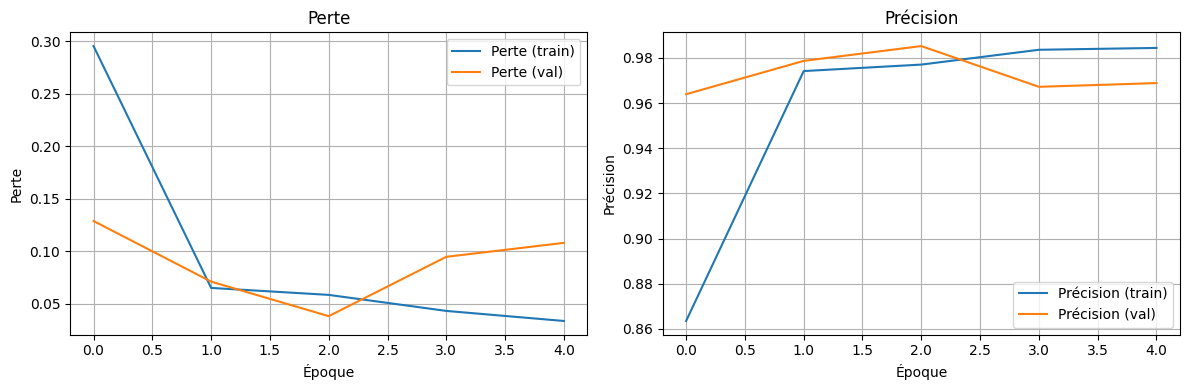


--- Phase d'Évaluation (sur les données de validation) ---


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step

Rapport de classification (sur les fenêtres de validation):
                    precision    recall  f1-score   support

Pas de Clic (Pred)       0.99      0.99      0.99       560
       Clic (Pred)       0.89      0.94      0.91        50

          accuracy                           0.99       610
         macro avg       0.94      0.96      0.95       610
      weighted avg       0.99      0.99      0.99       610



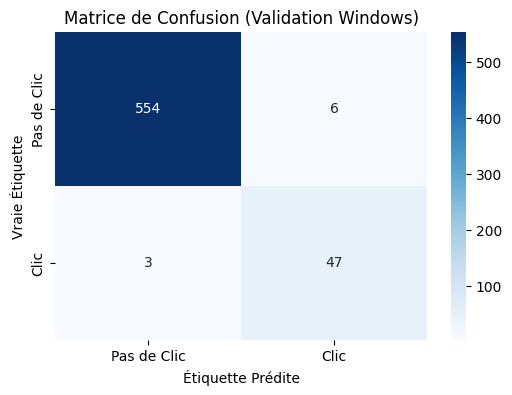


L'évaluation du timing fin nécessite un post-traitement plus avancé.

--- Phase d'Inférence ---


Modèle chargé depuis deblocage_lstm_model.h5 et scaler depuis scaler.joblib pour l'inférence.

Analyse du répertoire : c:\Users\Gabriel Franco\Informatique\Exosquelette\inference_dataset pour le mode 'inference'
Erreur : Le répertoire 'inference_dataset' n'existe pas.
Aucune donnée d'inférence n'a été chargée. Vérifiez INFERENCE_DATA_DIR et les fichiers.


In [ ]:
# Bloc 1: Imports et Paramètres Globaux pour l'IA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import joblib

WINDOW_SIZE = 150 # nb de points à prendre (freq=50Hz)
PREDICTION_HORIZON = 25
FEATURES_TO_USE = [
    'Acc_X_Raw (m/s^2)', 'Acc_Y_Raw (m/s^2)', 'Acc_Z_Raw (m/s^2)',
    'Gyro_X (rad/s)', 'Gyro_Y (rad/s)', 'Gyro_Z (rad/s)',
    'Force_Cable1 (N)', 'Force_Cable2 (N)',
    'Vel_X_Noisy (m/s)', 'Vel_Y_Noisy (m/s)', 'Vel_Z_Noisy (m/s)',
    'Angle_Pitch_Noisy (rad)', 'Angle_Yaw_Noisy (rad)'
]
SAMPLING_RATE = 50

# --- Bloc 2: Fonctions de Chargement et de Prétraitement des Données ---

# Compteur global pour limiter les messages de débogage aux premiers fichiers
DEBUG_FILE_COUNT_CREATE_SEQ = 0
MAX_DEBUG_FILES_CREATE_SEQ = 3

def get_second_click_time(button_states, sampling_rate_local):
    """Trouve l'indice et le temps du début du deuxième clic de bouton."""
    # Un clic est marqué par une transition de 0 à 1
    # np.diff() calcule la différence entre éléments consécutifs.
    # Une transition 0 -> 1 donnera une différence de 1.
    # L'indice retourné par np.where est celui *avant* la transition, donc on ajoute 1.
    clicks_start_indices = np.where(np.diff(button_states) == 1)[0] + 1

    # Gérer le cas où le premier clic est au tout début (index 0)
    if button_states[0] == 1:
        # S'il y avait déjà un clic détecté par diff, et que c'est le même, on ne le rajoute pas
        if not (len(clicks_start_indices) > 0 and clicks_start_indices[0] == 0):
             clicks_start_indices = np.insert(clicks_start_indices, 0, 0)
        elif not np.any(clicks_start_indices == 0): # S'assurer de ne pas dupliquer si déjà présent
             clicks_start_indices = np.insert(clicks_start_indices, 0, 0)


    if len(clicks_start_indices) >= 2:
        second_click_start_idx = clicks_start_indices[1]
        return second_click_start_idx, second_click_start_idx / sampling_rate_local
    return None, None

def create_sequences_and_labels_for_file(df, window_size, prediction_horizon, features, mode="training", sampling_rate_local=50, filename_for_debug="Unknown"):
    global DEBUG_FILE_COUNT_CREATE_SEQ

    X, y = [], []
    # S'assurer que Button_State est bien de type entier pour np.diff
    raw_button_state = df['Button_State'].values.astype(int)
    actual_second_click_idx, actual_second_click_time = None, None

    if DEBUG_FILE_COUNT_CREATE_SEQ < MAX_DEBUG_FILES_CREATE_SEQ:
        print(f"\n[Debug create_sequences] Fichier: {filename_for_debug}, Mode: {mode}")
        print(f"[Debug create_sequences] Button_State (premiers 200 points ou moins): {raw_button_state[:200]}")

        # Test de get_second_click_time pour ce fichier
        s_idx_dbg, s_time_dbg = get_second_click_time(raw_button_state, sampling_rate_local)
        if s_idx_dbg is not None:
            print(f"[Debug create_sequences] get_second_click_time a trouvé un 2e clic à l'index {s_idx_dbg} (temps {s_time_dbg:.2f}s)")
        else:
            print(f"[Debug create_sequences] get_second_click_time N'A PAS trouvé de 2e clic.")

    if mode == "training":
        actual_second_click_idx, actual_second_click_time = get_second_click_time(raw_button_state, sampling_rate_local)
        if actual_second_click_idx is None:
            if DEBUG_FILE_COUNT_CREATE_SEQ < MAX_DEBUG_FILES_CREATE_SEQ: # Limiter l'affichage des avertissements
                print(f"Avertissement [Fichier: {filename_for_debug}]: Aucun second clic trouvé pour l'étiquetage. Toutes les étiquettes pour ce fichier seront 0.")

    data_for_sequences = df[features].copy()

    positive_labels_found_in_file = 0
    for i in range(len(data_for_sequences) - window_size - prediction_horizon + 1):
        input_seq = data_for_sequences.iloc[i : i + window_size].values
        label = 0
        if mode == "training" and actual_second_click_idx is not None:
            start_predict_window_idx = i + window_size
            end_predict_window_idx = i + window_size + prediction_horizon
            if start_predict_window_idx <= actual_second_click_idx < end_predict_window_idx:
                label = 1
                positive_labels_found_in_file +=1

        X.append(input_seq)
        y.append(label)

    if DEBUG_FILE_COUNT_CREATE_SEQ < MAX_DEBUG_FILES_CREATE_SEQ:
        print(f"[Debug create_sequences] Fichier {filename_for_debug}: {positive_labels_found_in_file} étiquettes positives (1) créées.")
        if mode == "training": DEBUG_FILE_COUNT_CREATE_SEQ += 1

    return np.array(X), np.array(y), actual_second_click_time

def load_process_all_simulations(main_directory, mode, window_size, prediction_horizon, features, sampling_rate_local=50, scaler_obj=None):
    all_X = []
    all_y = []
    all_original_indices_and_files = []

    print(f"\nAnalyse du répertoire : {os.path.abspath(main_directory)} pour le mode '{mode}'")
    if not os.path.isdir(main_directory):
        print(f"Erreur : Le répertoire '{main_directory}' n'existe pas.")
        return np.array([]), np.array([]), [], None

    if mode == "training":
        simulation_files = [f for f in os.listdir(main_directory)
                            if (f.endswith('_training.xlsx') or (f.endswith('.xlsx') and 'inference' not in f.lower() and 'full_for_plot' not in f.lower()))
                            and os.path.isfile(os.path.join(main_directory, f))]
    elif mode == "inference":
        simulation_files = [f for f in os.listdir(main_directory)
                            if f.endswith('_inference.xlsx')
                            and os.path.isfile(os.path.join(main_directory, f))]
    else:
        simulation_files = []

    print(f"Fichiers trouvés correspondant au mode '{mode}': {simulation_files if simulation_files else 'Aucun'}")
    if not simulation_files:
        return np.array([]), np.array([]), [], None

    file_count = 0
    for filename in simulation_files:
        filepath = os.path.join(main_directory, filename)
        try:
            df = pd.read_excel(filepath)
            file_count += 1
            # Vérifier la présence de toutes les colonnes AVANT d'appeler create_sequences
            if not all(feat in df.columns for feat in features):
                print(f"Avertissement: Certaines caractéristiques de FEATURES_TO_USE sont manquantes dans {filename}. Fichier ignoré.")
                continue
            if 'Button_State' not in df.columns:
                print(f"Avertissement: Colonne 'Button_State' manquante dans {filename}. Fichier ignoré.")
                continue

            X_file, y_file, second_click_time_file = create_sequences_and_labels_for_file(
                df, window_size, prediction_horizon, features, mode, sampling_rate_local, filename_for_debug=filename
            )

            if X_file.shape[0] > 0:
                all_X.append(X_file)
                if mode == "training": # Les étiquettes ne sont pertinentes que pour le training
                    all_y.append(y_file)

                for seq_idx in range(X_file.shape[0]):
                    prediction_window_start_time = (seq_idx + window_size) / sampling_rate_local
                    all_original_indices_and_files.append({
                        "filename": filename,
                        "sequence_index_in_file": seq_idx,
                        "prediction_window_start_time": prediction_window_start_time,
                        "actual_second_click_time": second_click_time_file if mode == "training" else None
                    })
        except Exception as e:
            print(f"Erreur lors du traitement du fichier {filename}: {e}")

    print(f"{file_count} fichiers traités dans {main_directory}.")
    if not all_X:
        print("Aucune séquence n'a été créée à partir des fichiers trouvés.")
        return np.array([]), np.array([]), [], None

    X_combined = np.concatenate(all_X, axis=0)
    y_combined = np.concatenate(all_y, axis=0) if mode == "training" and all_y else np.array([])

    if X_combined.shape[0] == 0: # Vérification supplémentaire
        print("X_combined est vide après concaténation.")
        return np.array([]), np.array([]), [], None

    num_samples, num_timesteps, num_features = X_combined.shape
    X_reshaped = X_combined.reshape(-1, num_features)

    current_scaler = scaler_obj
    if mode == "training":
        print("Ajustement du scaler sur les données d'entraînement...")
        current_scaler = StandardScaler()
        X_scaled_reshaped = current_scaler.fit_transform(X_reshaped)
        print("Scaler ajusté.")
    elif current_scaler is not None:
        print("Utilisation du scaler fourni pour transformer les données...")
        X_scaled_reshaped = current_scaler.transform(X_reshaped)
        print("Données transformées.")
    else:
        print("Avertissement: Mode inférence sans scaler pré-ajusté fourni. Les données ne seront pas normalisées.")
        X_scaled_reshaped = X_reshaped

    X_scaled = X_scaled_reshaped.reshape(num_samples, num_timesteps, num_features)

    return X_scaled, y_combined, all_original_indices_and_files, current_scaler


# --- Bloc 3: Construction du Modèle LSTM ---
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# --- Bloc 4: Entraînement du Modèle ---
TRAINING_DATA_DIR = "training_dataset"
MODEL_FILEPATH = "deblocage_lstm_model.h5"
SCALER_FILEPATH = "scaler.joblib"

print("\n--- Phase d'Entraînement ---")
# Réinitialiser le compteur de débogage avant de charger les données d'entraînement
DEBUG_FILE_COUNT_CREATE_SEQ = 0
X_train_full, y_train_full, train_mapping_info, scaler = load_process_all_simulations(
    TRAINING_DATA_DIR,
    mode="training",
    window_size=WINDOW_SIZE,
    prediction_horizon=PREDICTION_HORIZON,
    features=FEATURES_TO_USE,
    sampling_rate_local=SAMPLING_RATE
)

if X_train_full.shape[0] > 0 and y_train_full.shape[0] > 0: # S'assurer que y_train_full n'est pas vide
    joblib.dump(scaler, SCALER_FILEPATH)
    print(f"Scaler sauvegardé dans {SCALER_FILEPATH}")

    # Vérifier s'il y a au moins deux classes pour stratify
    can_stratify = len(np.unique(y_train_full)) > 1

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, shuffle=True,
        stratify=y_train_full if can_stratify else None
    )

    print(f"Taille des données d'entraînement: {X_train.shape}, Étiquettes: {y_train.shape}")
    print(f"Taille des données de validation: {X_val.shape}, Étiquettes: {y_val.shape}")
    if len(y_train) > 0: print(f"Distribution des étiquettes (entraînement): {np.bincount(y_train.astype(int))}") # Cast en int pour bincount
    if len(y_val) > 0: print(f"Distribution des étiquettes (validation): {np.bincount(y_val.astype(int))}")

    # Vérifier la présence d'exemples positifs
    has_positive_train = len(y_train) > 0 and np.sum(y_train) > 0
    has_positive_val = len(y_val) > 0 and np.sum(y_val) > 0

    if not has_positive_train:
        print("Avertissement: L'ensemble d'entraînement ne contient pas d'exemples positifs (étiquette 1).")
    if not has_positive_val and X_val.shape[0] > 0 : # X_val peut être vide si X_train_full est trop petit
         print("Avertissement: L'ensemble de validation ne contient pas d'exemples positifs (étiquette 1).")

    if X_train.shape[0] > 0 and X_val.shape[0] > 0 and has_positive_train :
        model = build_lstm_model(input_shape=(WINDOW_SIZE, X_train.shape[2]))
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(MODEL_FILEPATH, monitor='val_accuracy', save_best_only=True, verbose=1)

        count_0 = np.sum(y_train == 0)
        count_1 = np.sum(y_train == 1) # Sera 0 si has_positive_train est faux, mais on a la condition avant

        # S'assurer que count_1 n'est pas zéro avant de calculer le poids
        if count_1 == 0:
            print("Erreur critique: Aucun exemple positif dans l'ensemble d'entraînement, impossible de calculer class_weight pour la classe 1.")
            class_w = {0: 1.0, 1: 1.0} # Poids par défaut
        else:
            weight_for_0 = (1 / count_0) * (len(y_train) / 2.0) if count_0 > 0 else 1.0
            weight_for_1 = (1 / count_1) * (len(y_train) / 2.0)
            class_w = {0: weight_for_0, 1: weight_for_1}
        print(f"Poids des classes calculés: {class_w}")

        history = model.fit(
            X_train, y_train,
            epochs=5,
            batch_size=64,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, model_checkpoint],
            class_weight=class_w
        )
        print(f"Modèle entraîné et meilleur modèle sauvegardé dans {MODEL_FILEPATH}")

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1); plt.plot(history.history['loss'], label='Perte (train)'); plt.plot(history.history['val_loss'], label='Perte (val)'); plt.title('Perte'); plt.xlabel('Époque'); plt.ylabel('Perte'); plt.legend(); plt.grid(True)
        plt.subplot(1, 2, 2); plt.plot(history.history['accuracy'], label='Précision (train)'); plt.plot(history.history['val_accuracy'], label='Précision (val)'); plt.title('Précision'); plt.xlabel('Époque'); plt.ylabel('Précision'); plt.legend(); plt.grid(True)
        plt.tight_layout(); plt.show()
    else:
        print("Pas assez de données, pas d'exemples positifs dans l'entraînement, ou ensemble de validation vide. L'entraînement est annulé.")
else:
    print("Aucune donnée d'entraînement n'a été chargée ou traitée. Vérifiez TRAINING_DATA_DIR et les fichiers.")

# --- Bloc 5: Évaluation du Modèle ---
print("\n--- Phase d'Évaluation (sur les données de validation) ---")
if os.path.exists(MODEL_FILEPATH) and 'X_val' in locals() and X_val.shape[0] > 0 and 'y_val' in locals() and y_val.shape[0] > 0:
    model = load_model(MODEL_FILEPATH)
    y_pred_proba_val = model.predict(X_val)
    y_pred_val = (y_pred_proba_val > 0.5).astype(int).flatten()

    print("\nRapport de classification (sur les fenêtres de validation):")
    # S'assurer que y_val et y_pred_val ont des labels pour les deux classes si possible, sinon le rapport peut être limité
    target_names_report = ['Pas de Clic (Pred)', 'Clic (Pred)']
    # Vérifier si les deux classes sont présentes dans y_val ou y_pred_val pour éviter les warnings de sklearn
    unique_labels_true = np.unique(y_val)
    unique_labels_pred = np.unique(y_pred_val)

    if len(unique_labels_true) < 2 or len(unique_labels_pred) < 2:
        print("Avertissement: Toutes les étiquettes (vraies ou prédites) appartiennent à une seule classe en validation.")
        # Afficher le rapport avec les labels présents
        present_labels = np.union1d(unique_labels_true, unique_labels_pred).astype(int)
        custom_target_names = [target_names_report[i] for i in present_labels]
        if not custom_target_names: # Si tout est vide
             print(classification_report(y_val, y_pred_val, zero_division=0))
        else:
             print(classification_report(y_val, y_pred_val, labels=present_labels, target_names=custom_target_names, zero_division=0))

    else:
        print(classification_report(y_val, y_pred_val, target_names=target_names_report, zero_division=0))

    cm = confusion_matrix(y_val, y_pred_val)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pas de Clic', 'Clic'], yticklabels=['Pas de Clic', 'Clic'])
    plt.title('Matrice de Confusion (Validation Windows)'); plt.ylabel('Vraie Étiquette'); plt.xlabel('Étiquette Prédite'); plt.show()

    print("\nL'évaluation du timing fin nécessite un post-traitement plus avancé.")
else:
    print("Modèle non entraîné ou pas de données de validation pour l'évaluation.")

# --- Bloc 6: Inférence sur de Nouvelles Données ---
INFERENCE_DATA_DIR = "inference_dataset"

print("\n--- Phase d'Inférence ---")
DEBUG_FILE_COUNT_CREATE_SEQ = 0 # Réinitialiser pour l'inférence
if os.path.exists(MODEL_FILEPATH) and os.path.exists(SCALER_FILEPATH):
    inference_model = load_model(MODEL_FILEPATH)
    scaler_for_inference = joblib.load(SCALER_FILEPATH)
    print(f"Modèle chargé depuis {MODEL_FILEPATH} et scaler depuis {SCALER_FILEPATH} pour l'inférence.")

    X_inference, _, inference_mapping_info, _ = load_process_all_simulations(
        INFERENCE_DATA_DIR,
        mode="inference",
        window_size=WINDOW_SIZE,
        prediction_horizon=PREDICTION_HORIZON,
        features=FEATURES_TO_USE,
        sampling_rate_local=SAMPLING_RATE,
        scaler_obj=scaler_for_inference
    )

    if X_inference.shape[0] > 0:
        print(f"Données d'inférence chargées et prétraitées: {X_inference.shape}")
        predictions_proba_inference = inference_model.predict(X_inference)

        first_inference_file_name = None
        if inference_mapping_info: # S'assurer que la liste n'est pas vide
            first_inference_file_name = inference_mapping_info[0]["filename"]

        indices_for_first_file = [i for i, mapping in enumerate(inference_mapping_info) if mapping["filename"] == first_inference_file_name]

        if indices_for_first_file and first_inference_file_name is not None: # Vérifier aussi que le nom du fichier est défini
            start_idx = indices_for_first_file[0]
            end_idx = indices_for_first_file[-1] + 1

            plt.figure(figsize=(15, 6))
            prediction_times_for_plot = [m["prediction_window_start_time"] for m in inference_mapping_info[start_idx:end_idx]]

            plt.plot(prediction_times_for_plot, predictions_proba_inference[start_idx:end_idx], label=f"Probabilité de déblocage (Sim: {first_inference_file_name})")
            plt.axhline(0.5, color='r', linestyle='--', label="Seuil de décision (0.5)")
            plt.title(f"Probabilités de Prédiction sur la Simulation d'Inférence: {first_inference_file_name}")
            plt.xlabel("Temps (s) - Début de la fenêtre de prédiction")
            plt.ylabel("Probabilité de Déblocage"); plt.legend(); plt.grid(True); plt.ylim(0,1); plt.show()

            threshold = 0.7
            persistence_steps = int(0.1 * SAMPLING_RATE) # Ex: 0.1s de persistance
            predicted_deblocage_time = None

            proba_first_file = predictions_proba_inference[start_idx:end_idx].flatten()
            for k in range(len(proba_first_file) - persistence_steps + 1):
                if np.all(proba_first_file[k : k + persistence_steps] > threshold):
                    predicted_deblocage_time = prediction_times_for_plot[k]
                    print(f"Événement de déblocage PRÉDIT pour {first_inference_file_name} à ~{predicted_deblocage_time:.2f}s (prob > {threshold} pendant {persistence_steps*DT:.2f}s)")
                    break
            if predicted_deblocage_time is None:
                print(f"Aucun événement de déblocage prédit pour {first_inference_file_name} avec les critères actuels.")
        else:
            print("Impossible d'isoler les prédictions pour la première simulation d'inférence ou aucune information de mapping.")

    else:
        print("Aucune donnée d'inférence n'a été chargée. Vérifiez INFERENCE_DATA_DIR et les fichiers.")
else:
    print(f"Aucun modèle ({MODEL_FILEPATH}) ou scaler ({SCALER_FILEPATH}) entraîné trouvé. Veuillez d'abord entraîner le modèle.")



--- Analyse des Erreurs de Prédiction ---


Modèle chargé depuis deblocage_lstm_model.h5
Scaler chargé depuis scaler.joblib
Fichiers de test trouvés dans 'training_dataset': 10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step
[Debug Analyse] Fichier simulation_10_training.xlsx: Clic réel à 5.90s.
[Debug Analyse] Fichier simulation_10_training.xlsx: Clic prédit à 5.46s.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
[Debug Analyse] Fichier simulation_1_training.xlsx: Clic réel à 5.92s.
[Debug Analyse] Fichier simulation_1_training.xlsx: Clic prédit à 5.44s.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

10 fichiers de test traités pour l'analyse des erreurs.


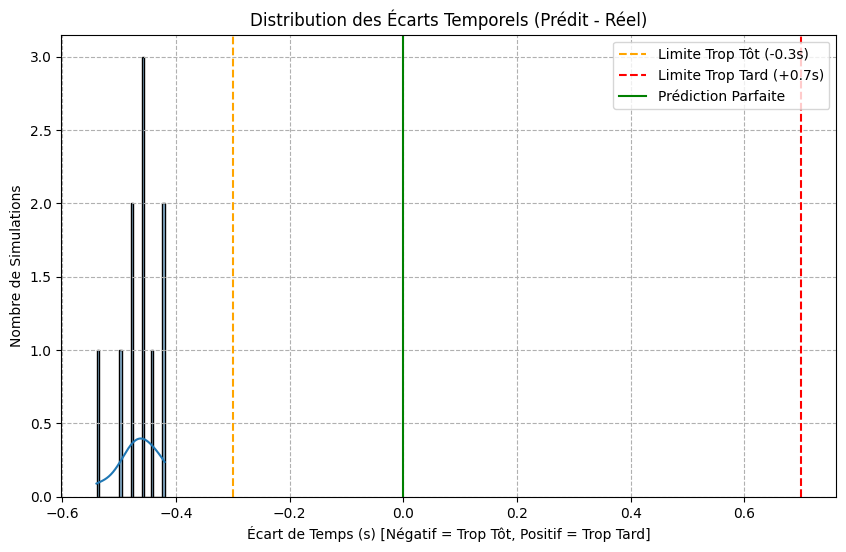


Statistiques sur les Écarts Temporels :
  Moyenne de l'écart: -0.466 s
  Médiane de l'écart: -0.460 s
  Écart-type de l'écart: 0.035 s
  Min écart: -0.540 s
  Max écart: -0.420 s

Catégorisation des Prédictions :
  Bonnes Prédictions (Hits) [-0.3s, +0.7s]: 0 (0.0%)
  Prédictions Trop Précoces (< -0.3s): 10 (100.0%)
  Prédictions Trop Tardives (> +0.7s et <= 2.0s): 0 (0.0%)
  Prédictions Manquées/Très Tardives (> 2.0s ou non prédit): 0 (0.0%)


In [3]:
# Bloc (Cellule) pour l'Analyse des Erreurs de Prédiction
# Ce bloc suppose que les blocs précédents (imports, fonctions utilitaires,
# et potentiellement l'entraînement si vous voulez ré-évaluer sur les données de validation)
# ont été exécutés ou que les artefacts nécessaires (modèle, scaler) sont disponibles.

from tensorflow.keras.models import load_model # Pour charger le modèle
from sklearn.metrics import classification_report, confusion_matrix

# --- Paramètres pour l'Analyse des Erreurs ---
# Assurez-vous que ces paramètres sont cohérents avec ceux utilisés pour l'entraînement
WINDOW_SIZE_ANALYSIS = 150  # CORRIGÉ: Doit correspondre au WINDOW_SIZE de l'entraînement (3 secondes * 50 Hz)
PREDICTION_HORIZON_ANALYSIS = 25 # Utilisé par create_sequences_and_labels_for_file (si on l'utilisait)
FEATURES_TO_USE_ANALYSIS = [
    'Acc_X_Raw (m/s^2)', 'Acc_Y_Raw (m/s^2)', 'Acc_Z_Raw (m/s^2)',
    'Gyro_X (rad/s)', 'Gyro_Y (rad/s)', 'Gyro_Z (rad/s)',
    'Force_Cable1 (N)', 'Force_Cable2 (N)',
    'Vel_X_Noisy (m/s)', 'Vel_Y_Noisy (m/s)', 'Vel_Z_Noisy (m/s)',
    'Angle_Pitch_Noisy (rad)', 'Angle_Yaw_Noisy (rad)'
]
SAMPLING_RATE_ANALYSIS = 50
DT_ANALYSIS = 1.0 / SAMPLING_RATE_ANALYSIS

# Chemins vers le modèle et le scaler sauvegardés
MODEL_FILEPATH_ANALYSIS = "deblocage_lstm_model.h5"
SCALER_FILEPATH_ANALYSIS = "scaler.joblib"

# Répertoire contenant les données de "training" qui serviront de test pour cette analyse
# car elles contiennent le 2ème clic (vérité terrain)
TEST_DATA_DIR_FOR_ERROR_ANALYSIS = "training_dataset"

# Critères pour identifier une prédiction de déblocage par le modèle
PREDICTION_THRESHOLD = 0.7
PERSISTENCE_STEPS = int(0.1 * SAMPLING_RATE_ANALYSIS)

# Fenêtres de tolérance pour catégoriser les prédictions
TOLERANCE_EARLY_S = 0.3
TOLERANCE_LATE_S = 0.7
MAX_ACCEPTABLE_DELAY_S = 2.0

DEBUG_FILE_COUNT_ANALYSIS = 0
MAX_DEBUG_FILES_ANALYSIS = 2

def get_second_click_time_analysis(button_states, sampling_rate_local):
    clicks_start_indices = np.where(np.diff(button_states.astype(int)) == 1)[0] + 1
    if len(button_states) > 0 and button_states[0] == 1: # Vérifier que button_states n'est pas vide
        if not (len(clicks_start_indices) > 0 and clicks_start_indices[0] == 0):
             clicks_start_indices = np.insert(clicks_start_indices, 0, 0)
        elif not np.any(clicks_start_indices == 0):
             clicks_start_indices = np.insert(clicks_start_indices, 0, 0)
    if len(clicks_start_indices) >= 2:
        return clicks_start_indices[1], clicks_start_indices[1] / sampling_rate_local
    return None, None

def create_sequences_for_prediction_analysis(df, window_size, features):
    X = []
    if not all(feat in df.columns for feat in features): # Vérifier que toutes les features sont là
        print(f"Avertissement: Colonnes manquantes dans le DataFrame pour create_sequences_for_prediction_analysis. Features attendues: {features}, Colonnes DataFrame: {df.columns.tolist()}")
        return np.array(X)

    data_for_sequences = df[features].copy()
    for i in range(len(data_for_sequences) - window_size + 1):
        input_seq = data_for_sequences.iloc[i : i + window_size].values
        X.append(input_seq)
    return np.array(X)

def find_predicted_deblocage_event_time(probabilities, window_start_times, threshold, persistence_steps, dt_local):
    if probabilities is None or len(probabilities) < persistence_steps:
        return None
    for i in range(len(probabilities) - persistence_steps + 1):
        if np.all(probabilities[i : i + persistence_steps] > threshold):
            return window_start_times[i]
    return None

# --- Script Principal d'Analyse des Erreurs ---

print("--- Analyse des Erreurs de Prédiction ---")

if not (os.path.exists(MODEL_FILEPATH_ANALYSIS) and os.path.exists(SCALER_FILEPATH_ANALYSIS)):
    print(f"Erreur: Modèle ({MODEL_FILEPATH_ANALYSIS}) ou Scaler ({SCALER_FILEPATH_ANALYSIS}) non trouvé.")
    print("Veuillez exécuter le script d'entraînement d'abord.")
else:
    model = load_model(MODEL_FILEPATH_ANALYSIS)
    scaler = joblib.load(SCALER_FILEPATH_ANALYSIS)
    print(f"Modèle chargé depuis {MODEL_FILEPATH_ANALYSIS}")
    print(f"Scaler chargé depuis {SCALER_FILEPATH_ANALYSIS}")

    if not os.path.isdir(TEST_DATA_DIR_FOR_ERROR_ANALYSIS):
        print(f"Erreur: Le répertoire de test '{TEST_DATA_DIR_FOR_ERROR_ANALYSIS}' n'existe pas.")
    else:
        test_simulation_files = [f for f in os.listdir(TEST_DATA_DIR_FOR_ERROR_ANALYSIS)
                                 if (f.endswith('_training.xlsx') or (f.endswith('.xlsx') and 'inference' not in f.lower() and 'full_for_plot' not in f.lower()))
                                 and os.path.isfile(os.path.join(TEST_DATA_DIR_FOR_ERROR_ANALYSIS, f))]

        print(f"Fichiers de test trouvés dans '{TEST_DATA_DIR_FOR_ERROR_ANALYSIS}': {len(test_simulation_files)}")

        time_differences = []
        prediction_categories = {"hit": 0, "early": 0, "late": 0, "missed_event": 0, "no_true_event": 0}
        processed_files_count = 0

        for filename in test_simulation_files:
            filepath = os.path.join(TEST_DATA_DIR_FOR_ERROR_ANALYSIS, filename)
            try:
                df_test = pd.read_excel(filepath)
                processed_files_count += 1

                if 'Button_State' not in df_test.columns:
                    print(f"Avertissement: Colonne 'Button_State' manquante dans {filename}. Fichier ignoré pour l'analyse de timing.")
                    prediction_categories["no_true_event"] +=1 # Ou une autre catégorie d'erreur
                    continue

                button_state_test = df_test['Button_State'].values.astype(int)
                actual_second_click_idx, actual_second_click_time = get_second_click_time_analysis(button_state_test, SAMPLING_RATE_ANALYSIS)

                if actual_second_click_time is None:
                    prediction_categories["no_true_event"] += 1
                    if DEBUG_FILE_COUNT_ANALYSIS < MAX_DEBUG_FILES_ANALYSIS:
                        print(f"[Debug Analyse] Fichier {filename}: Pas de 2ème clic réel trouvé. Ignoré pour l'analyse d'erreur de timing.")
                    continue # Passer au fichier suivant si pas de 2e clic réel

                X_file_test_raw = create_sequences_for_prediction_analysis(df_test, WINDOW_SIZE_ANALYSIS, FEATURES_TO_USE_ANALYSIS)

                if X_file_test_raw.shape[0] == 0:
                    if DEBUG_FILE_COUNT_ANALYSIS < MAX_DEBUG_FILES_ANALYSIS:
                        print(f"[Debug Analyse] Fichier {filename}: Aucune séquence générée (peut-être trop court pour WINDOW_SIZE_ANALYSIS={WINDOW_SIZE_ANALYSIS}). Ignoré.")
                    continue

                num_s, num_ts, num_f = X_file_test_raw.shape
                X_file_test_reshaped = X_file_test_raw.reshape(-1, num_f)
                X_file_test_scaled_reshaped = scaler.transform(X_file_test_reshaped)
                X_file_test_scaled = X_file_test_scaled_reshaped.reshape(num_s, num_ts, num_f)

                probabilities_file = model.predict(X_file_test_scaled).flatten()

                # Le temps de début de la *fenêtre de prédiction* est (index_sequence + window_size) * dt
                # car la prédiction concerne ce qui se passe *après* la fenêtre d'entrée.
                prediction_window_start_times_file = (np.arange(len(probabilities_file)) + WINDOW_SIZE_ANALYSIS) * DT_ANALYSIS

                predicted_deblocage_time = find_predicted_deblocage_event_time(
                    probabilities_file,
                    prediction_window_start_times_file,
                    PREDICTION_THRESHOLD,
                    PERSISTENCE_STEPS,
                    DT_ANALYSIS
                )

                if DEBUG_FILE_COUNT_ANALYSIS < MAX_DEBUG_FILES_ANALYSIS:
                    print(f"[Debug Analyse] Fichier {filename}: Clic réel à {actual_second_click_time:.2f}s.")
                    if predicted_deblocage_time is not None:
                        print(f"[Debug Analyse] Fichier {filename}: Clic prédit à {predicted_deblocage_time:.2f}s.")
                    else:
                        print(f"[Debug Analyse] Fichier {filename}: Aucun clic prédit par le modèle avec les critères actuels.")

                if predicted_deblocage_time is not None:
                    diff = predicted_deblocage_time - actual_second_click_time
                    time_differences.append(diff)

                    if diff < (-TOLERANCE_EARLY_S):
                        prediction_categories["early"] += 1
                    elif diff > TOLERANCE_LATE_S:
                        if diff <= MAX_ACCEPTABLE_DELAY_S :
                            prediction_categories["late"] += 1
                        else:
                            prediction_categories["missed_event"] +=1
                    else:
                        prediction_categories["hit"] += 1
                else:
                    prediction_categories["missed_event"] += 1

                if DEBUG_FILE_COUNT_ANALYSIS < MAX_DEBUG_FILES_ANALYSIS and processed_files_count <= MAX_DEBUG_FILES_ANALYSIS:
                    DEBUG_FILE_COUNT_ANALYSIS +=1

            except ValueError as ve: # Attraper spécifiquement les erreurs de shape
                print(f"Erreur de valeur (potentiellement shape) lors du traitement de {filename}: {ve}")
                print("Vérifiez que WINDOW_SIZE_ANALYSIS correspond à la taille de fenêtre de l'entraînement du modèle.")
            except Exception as e:
                print(f"Erreur générale lors du traitement du fichier de test {filename} pour l'analyse d'erreur: {e}")

        print(f"\n{processed_files_count} fichiers de test traités pour l'analyse des erreurs.")
        if time_differences:
            time_differences = np.array(time_differences)

            plt.figure(figsize=(10, 6))
            sns.histplot(time_differences, kde=True, bins=30)
            plt.title("Distribution des Écarts Temporels (Prédit - Réel)")
            plt.xlabel("Écart de Temps (s) [Négatif = Trop Tôt, Positif = Trop Tard]")
            plt.ylabel("Nombre de Simulations")
            plt.grid(True, linestyle='--')
            plt.axvline(-TOLERANCE_EARLY_S, color='orange', linestyle='--', label=f'Limite Trop Tôt (-{TOLERANCE_EARLY_S}s)')
            plt.axvline(TOLERANCE_LATE_S, color='red', linestyle='--', label=f'Limite Trop Tard (+{TOLERANCE_LATE_S}s)')
            plt.axvline(0, color='green', linestyle='-', label='Prédiction Parfaite')
            plt.legend()
            plt.show()

            print("\nStatistiques sur les Écarts Temporels :")
            print(f"  Moyenne de l'écart: {np.mean(time_differences):.3f} s")
            print(f"  Médiane de l'écart: {np.median(time_differences):.3f} s")
            print(f"  Écart-type de l'écart: {np.std(time_differences):.3f} s")
            print(f"  Min écart: {np.min(time_differences):.3f} s")
            print(f"  Max écart: {np.max(time_differences):.3f} s")

            print("\nCatégorisation des Prédictions :")
            total_evaluated_events = prediction_categories["hit"] + prediction_categories["early"] + prediction_categories["late"] + prediction_categories["missed_event"]
            if total_evaluated_events > 0:
                print(f"  Bonnes Prédictions (Hits) [-{TOLERANCE_EARLY_S}s, +{TOLERANCE_LATE_S}s]: {prediction_categories['hit']} ({prediction_categories['hit']/total_evaluated_events*100:.1f}%)")
                print(f"  Prédictions Trop Précoces (< -{TOLERANCE_EARLY_S}s): {prediction_categories['early']} ({prediction_categories['early']/total_evaluated_events*100:.1f}%)")
                print(f"  Prédictions Trop Tardives (> +{TOLERANCE_LATE_S}s et <= {MAX_ACCEPTABLE_DELAY_S}s): {prediction_categories['late']} ({prediction_categories['late']/total_evaluated_events*100:.1f}%)")
                print(f"  Prédictions Manquées/Très Tardives (> {MAX_ACCEPTABLE_DELAY_S}s ou non prédit): {prediction_categories['missed_event']} ({prediction_categories['missed_event']/total_evaluated_events*100:.1f}%)")
            else:
                print("Aucun événement n'a pu être évalué (vérifiez les données et les seuils).")
            if prediction_categories["no_true_event"] > 0:
                 print(f"  Simulations ignorées car pas de 2ème clic réel: {prediction_categories['no_true_event']}")
        else:
            print("Aucun écart temporel n'a pu être calculé. Vérifiez les données de test et les prédictions du modèle.")



--- Phase d'Entraînement ---
Choix pour l'entraînement : Modèle LSTM

Analyse du répertoire : c:\Users\Gabriel Franco\Informatique\Exosquelette\training_dataset pour le mode 'training'
Fichiers trouvés correspondant au mode 'training': ['simulation_10_training.xlsx', 'simulation_1_training.xlsx', 'simulation_2_training.xlsx', 'simulation_3_training.xlsx', 'simulation_4_training.xlsx', 'simulation_5_training.xlsx', 'simulation_6_training.xlsx', 'simulation_7_training.xlsx', 'simulation_8_training.xlsx', 'simulation_9_training.xlsx']

[Debug create_sequences] Fichier: simulation_10_training.xlsx, Mode: training
[Debug create_sequences] 2e clic trouvé à l'index 333 (temps 6.66s)
[Debug create_sequences] Fichier simulation_10_training.xlsx: 25 étiquettes positives (1) créées.

[Debug create_sequences] Fichier: simulation_1_training.xlsx, Mode: training
[Debug create_sequences] 2e clic trouvé à l'index 294 (temps 5.88s)
[Debug create_sequences] Fichier simulation_1_training.xlsx: 25 étique

c:\Users\Gabriel Franco\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 150, 128)       │        39,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,265 (325.25 KB)

 Trainable params: 83,265 (325.25 KB)

 Non-trainable params: 0 (0.00 B)

Poids des classes pour l'entraînement: {0: 0.5435161009573543, 1: 6.245}
Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.6917 - loss: 0.4197
Epoch 1: val_accuracy improved from -inf to 0.96640, saving model to deblocage_model_lstm.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 414ms/step - accuracy: 0.6955 - loss: 0.4158 - val_accuracy: 0.9664 - val_loss: 0.0919
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9762 - loss: 0.0517
Epoch 2: val_accuracy improved from 0.96640 to 0.96960, saving model to deblocage_model_lstm.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 402ms/step - accuracy: 0.9762 - loss: 0.0519 - val_accuracy: 0.9696 - val_loss: 0.0878
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9737 - loss: 0.0498
Epoch 3: val_accuracy improved from 0.96960 to 0.97920, saving model to deblocage_model_lstm.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 389ms/step - accuracy: 0.9737 - loss: 0.0497 - val_accuracy: 0.9792 - val_loss: 0.0526
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9865 - loss: 0.0315
Epoch 4: val_accuracy improved from 0.97920 to 0.98080, saving model to deblocage_model_lstm.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 371ms/step - accuracy: 0.9865 - loss: 0.0314 - val_accuracy: 0.9808 - val_loss: 0.0573
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9821 - loss: 0.0581
Epoch 5: val_accuracy improved from 0.98080 to 0.98880, saving model to deblocage_model_lstm.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 400ms/step - accuracy: 0.9819 - loss: 0.0583 - val_accuracy: 0.9888 - val_loss: 0.0325
Modèle lstm entraîné et meilleur modèle sauvegardé dans deblocage_model_lstm.h5

--- Performance finale du modèle LSTM sur l'ensemble de validation (après entraînement) ---
Perte de validation finale: 0.0325
Précision de validation finale: 0.9888


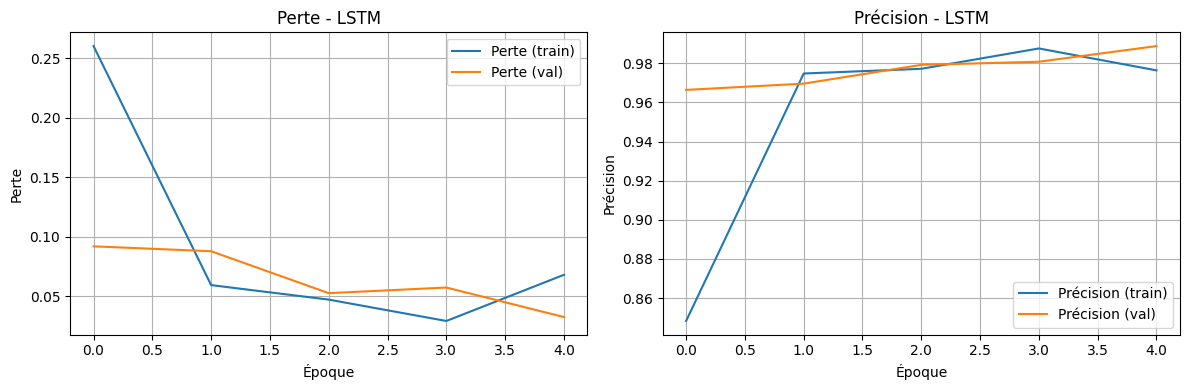


--- Phase d'Analyse des Erreurs de Prédiction ---


Choix pour l'analyse : Modèle LSTM
Modèle et scaler chargés pour l'analyse (lstm).
Utilisation de l'ensemble de validation précédent pour l'analyse des erreurs.
Données pour analyse chargées: (625, 150, 13)
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step

--- Rapport de Classification (par fenêtre) pour Modèle LSTM sur les données d'analyse ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       575
           1       0.88      1.00      0.93        50

    accuracy                           0.99       625
   macro avg       0.94      0.99      0.96       625
weighted avg       0.99      0.99      0.99       625



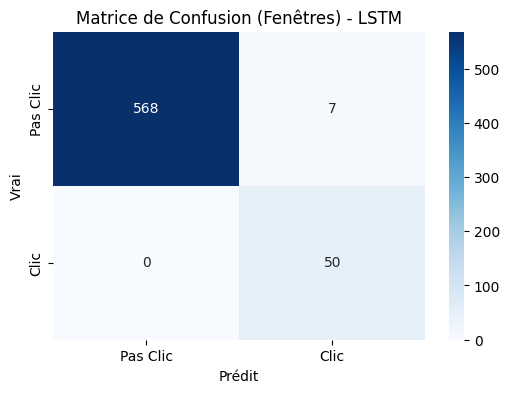

Aucun écart temporel calculé pour l'analyse des erreurs de timing.

--- Phase d'Inférence ---


Choix pour l'inférence : Modèle LSTM
Modèle lstm et scaler chargés pour l'inférence.

Analyse du répertoire : c:\Users\Gabriel Franco\Informatique\Exosquelette\inference_dataset pour le mode 'inference'
Erreur : Le répertoire 'inference_dataset' n'existe pas.
Aucune donnée chargée depuis inference_dataset pour le mode inference.


In [4]:
# Bloc 1: Imports et Paramètres Globaux pour l'IA
# Paramètres pour la préparation des séquences et la prédiction
WINDOW_SIZE = 150  # 3 secondes * 50 Hz
PREDICTION_HORIZON = 25
FEATURES_TO_USE = [
    'Acc_X_Raw (m/s^2)', 'Acc_Y_Raw (m/s^2)', 'Acc_Z_Raw (m/s^2)',
    'Gyro_X (rad/s)', 'Gyro_Y (rad/s)', 'Gyro_Z (rad/s)',
    'Force_Cable1 (N)', 'Force_Cable2 (N)',
    'Vel_X_Noisy (m/s)', 'Vel_Y_Noisy (m/s)', 'Vel_Z_Noisy (m/s)',
    'Angle_Pitch_Noisy (rad)', 'Angle_Yaw_Noisy (rad)'
]
SAMPLING_RATE = 50
DT = 1.0 / SAMPLING_RATE

BASE_MODEL_FILENAME = "deblocage_model"
BASE_SCALER_FILENAME = "scaler"
TRAINING_DATA_DIR = "training_dataset"
INFERENCE_DATA_DIR = "inference_dataset"

PREDICTION_THRESHOLD_ANALYSIS = 0.7
PERSISTENCE_STEPS_ANALYSIS = int(0.1 * SAMPLING_RATE)
TOLERANCE_EARLY_S_ANALYSIS = 0.3
TOLERANCE_LATE_S_ANALYSIS = 0.7
MAX_ACCEPTABLE_DELAY_S_ANALYSIS = 2.0

# --- Bloc 2: Fonctions de Chargement et de Prétraitement des Données ---
DEBUG_FILE_COUNT_LOAD_PROCESS = 0
MAX_DEBUG_FILES_LOAD_PROCESS = 2 # Mettre à 0 pour désactiver le debug détaillé du chargement

def get_second_click_time(button_states, sampling_rate_local):
    clicks_start_indices = np.where(np.diff(button_states.astype(int)) == 1)[0] + 1
    if len(button_states) > 0 and button_states[0] == 1:
        if not (len(clicks_start_indices) > 0 and clicks_start_indices[0] == 0):
             clicks_start_indices = np.insert(clicks_start_indices, 0, 0)
        elif not np.any(clicks_start_indices == 0):
             clicks_start_indices = np.insert(clicks_start_indices, 0, 0)
    if len(clicks_start_indices) >= 2:
        return clicks_start_indices[1], clicks_start_indices[1] / sampling_rate_local
    return None, None

def create_sequences_and_labels_for_file(df, window_size, prediction_horizon, features, mode="training", sampling_rate_local=50, filename_for_debug="Unknown"):
    global DEBUG_FILE_COUNT_LOAD_PROCESS
    X, y = [], []
    raw_button_state = df['Button_State'].values.astype(int)
    actual_second_click_idx, actual_second_click_time = None, None

    if DEBUG_FILE_COUNT_LOAD_PROCESS < MAX_DEBUG_FILES_LOAD_PROCESS and mode == "training":
        print(f"\n[Debug create_sequences] Fichier: {filename_for_debug}, Mode: {mode}")
        s_idx_dbg, s_time_dbg = get_second_click_time(raw_button_state, sampling_rate_local)
        if s_idx_dbg is not None: print(f"[Debug create_sequences] 2e clic trouvé à l'index {s_idx_dbg} (temps {s_time_dbg:.2f}s)")
        else: print(f"[Debug create_sequences] PAS de 2e clic trouvé.")

    if mode == "training":
        actual_second_click_idx, actual_second_click_time = get_second_click_time(raw_button_state, sampling_rate_local)
        if actual_second_click_idx is None and DEBUG_FILE_COUNT_LOAD_PROCESS < MAX_DEBUG_FILES_LOAD_PROCESS:
            print(f"Avertissement [Fichier: {filename_for_debug}]: Aucun 2e clic pour étiquetage. Étiquettes seront 0.")

    data_for_sequences = df[features].copy()
    positive_labels_found_in_file = 0
    for i in range(len(data_for_sequences) - window_size - prediction_horizon + 1):
        input_seq = data_for_sequences.iloc[i : i + window_size].values
        label = 0
        if mode == "training" and actual_second_click_idx is not None:
            start_predict_window_idx = i + window_size
            end_predict_window_idx = i + window_size + prediction_horizon
            if start_predict_window_idx <= actual_second_click_idx < end_predict_window_idx:
                label = 1
                positive_labels_found_in_file +=1
        X.append(input_seq)
        y.append(label)

    if DEBUG_FILE_COUNT_LOAD_PROCESS < MAX_DEBUG_FILES_LOAD_PROCESS and mode == "training":
        print(f"[Debug create_sequences] Fichier {filename_for_debug}: {positive_labels_found_in_file} étiquettes positives (1) créées.")
        DEBUG_FILE_COUNT_LOAD_PROCESS += 1
    return np.array(X), np.array(y), actual_second_click_time

def load_process_all_simulations(main_directory, mode, window_size, prediction_horizon, features, sampling_rate_local=50, scaler_obj=None):
    all_X, all_y, all_original_indices_and_files = [], [], []
    print(f"\nAnalyse du répertoire : {os.path.abspath(main_directory)} pour le mode '{mode}'")
    if not os.path.isdir(main_directory):
        print(f"Erreur : Le répertoire '{main_directory}' n'existe pas."); return np.array([]), np.array([]), [], None

    file_pattern_suffix = f"_{mode}.xlsx"
    simulation_files = [f for f in os.listdir(main_directory) if f.endswith(file_pattern_suffix) and os.path.isfile(os.path.join(main_directory, f))]

    if mode == "training" and not simulation_files:
        print(f"Aucun fichier '{file_pattern_suffix}' trouvé. Recherche de fichiers '.xlsx' génériques pour le training...")
        simulation_files = [f for f in os.listdir(main_directory)
                            if f.endswith('.xlsx') and 'inference' not in f.lower() and 'full_for_plot' not in f.lower()
                            and os.path.isfile(os.path.join(main_directory, f))]

    print(f"Fichiers trouvés correspondant au mode '{mode}': {simulation_files if simulation_files else 'Aucun'}")
    if not simulation_files: return np.array([]), np.array([]), [], None

    file_count = 0
    for filename in simulation_files:
        filepath = os.path.join(main_directory, filename)
        try:
            df = pd.read_excel(filepath)
            file_count += 1
            if not all(feat in df.columns for feat in features):
                print(f"Avertissement: Caractéristiques manquantes dans {filename}. Ignoré."); continue
            if 'Button_State' not in df.columns:
                print(f"Avertissement: 'Button_State' manquant dans {filename}. Ignoré."); continue

            X_file, y_file, second_click_time_file = create_sequences_and_labels_for_file(
                df, window_size, prediction_horizon, features, mode, sampling_rate_local, filename_for_debug=filename)
            if X_file.shape[0] > 0:
                all_X.append(X_file)
                if mode == "training": all_y.append(y_file)
                for seq_idx in range(X_file.shape[0]):
                    all_original_indices_and_files.append({
                        "filename": filename, "sequence_index_in_file": seq_idx,
                        "prediction_window_start_time": (seq_idx + window_size) / sampling_rate_local,
                        "actual_second_click_time": second_click_time_file if mode == "training" else None})
        except Exception as e: print(f"Erreur traitant {filename}: {e}")

    print(f"{file_count} fichiers traités dans {main_directory}.")
    if not all_X: print("Aucune séquence créée."); return np.array([]), np.array([]), [], None

    X_combined = np.concatenate(all_X, axis=0)
    y_combined = np.concatenate(all_y, axis=0) if mode == "training" and all_y else np.array([])
    if X_combined.shape[0] == 0: return np.array([]), np.array([]), [], None

    num_samples, num_timesteps, num_features = X_combined.shape
    X_reshaped = X_combined.reshape(-1, num_features)
    current_scaler = scaler_obj
    if mode == "training":
        print("Ajustement du scaler..."); current_scaler = StandardScaler(); X_scaled_reshaped = current_scaler.fit_transform(X_reshaped); print("Scaler ajusté.")
    elif current_scaler is not None:
        print("Transformation avec scaler fourni..."); X_scaled_reshaped = current_scaler.transform(X_reshaped); print("Données transformées.")
    else:
        print("Avertissement: Pas de scaler pour l'inférence."); X_scaled_reshaped = X_reshaped
    X_scaled = X_scaled_reshaped.reshape(num_samples, num_timesteps, num_features)
    return X_scaled, y_combined, all_original_indices_and_files, current_scaler

# --- Bloc 3: Définitions des Modèles ---
def build_lstm_model(input_shape):
    model = Sequential(name="LSTM_Model")
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print("\n--- Architecture du Modèle LSTM ---")
    model.summary()
    return model

def build_cnn_lstm_model(input_shape):
    model = Sequential(name="CNN_LSTM_Model")
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print("\n--- Architecture du Modèle CNN-LSTM ---")
    model.summary()
    return model

# --- Bloc 4: Entraînement du Modèle ---
print("\n--- Phase d'Entraînement ---")
model_type_to_train = ""
while model_type_to_train not in ["lstm", "cnn-lstm"]:
    model_type_to_train = input("Quel type de modèle entraîner ('lstm' ou 'cnn-lstm') ? ").lower()
print(f"Choix pour l'entraînement : Modèle {model_type_to_train.upper()}")

model_filepath_train = f"{BASE_MODEL_FILENAME}_{model_type_to_train}.h5"
scaler_filepath_train = f"{BASE_SCALER_FILENAME}_{model_type_to_train}.joblib"

DEBUG_FILE_COUNT_LOAD_PROCESS = 0
X_train_full, y_train_full, train_mapping_info, scaler_train = load_process_all_simulations(
    TRAINING_DATA_DIR, mode="training", window_size=WINDOW_SIZE,
    prediction_horizon=PREDICTION_HORIZON, features=FEATURES_TO_USE, sampling_rate_local=SAMPLING_RATE
)

if X_train_full.shape[0] > 0 and y_train_full.shape[0] > 0:
    joblib.dump(scaler_train, scaler_filepath_train)
    print(f"Scaler sauvegardé dans {scaler_filepath_train}")

    can_stratify_train = len(np.unique(y_train_full)) > 1
    X_train, X_val, y_train, y_val, mapping_train, mapping_val = train_test_split(
        X_train_full, y_train_full, train_mapping_info, # Inclure le mapping dans le split
        test_size=0.2, shuffle=True, stratify=y_train_full if can_stratify_train else None
    )

    print(f"Entraînement: X_train={X_train.shape}, y_train={y_train.shape}, X_val={X_val.shape}, y_val={y_val.shape}")
    if len(y_train) > 0: print(f"Distr. y_train: {np.bincount(y_train.astype(int))}")
    if len(y_val) > 0: print(f"Distr. y_val: {np.bincount(y_val.astype(int))}")

    has_pos_train = len(y_train) > 0 and np.sum(y_train) > 0

    if X_train.shape[0] > 0 and X_val.shape[0] > 0 and has_pos_train:
        print(f"\nConstruction et entraînement du modèle : {model_type_to_train.upper()}")
        if model_type_to_train == "lstm":
            model_to_train = build_lstm_model(input_shape=(WINDOW_SIZE, X_train.shape[2]))
        else:
            model_to_train = build_cnn_lstm_model(input_shape=(WINDOW_SIZE, X_train.shape[2]))

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(model_filepath_train, monitor='val_accuracy', save_best_only=True, verbose=1)

        count_0, count_1 = np.sum(y_train == 0), np.sum(y_train == 1)
        class_w_train = {0: (1/count_0)*(len(y_train)/2.0) if count_0>0 else 1, 1: (1/count_1)*(len(y_train)/2.0) if count_1>0 else 1}
        print(f"Poids des classes pour l'entraînement: {class_w_train}")

        history = model_to_train.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val),
                                 callbacks=[early_stopping, model_checkpoint], class_weight=class_w_train)
        print(f"Modèle {model_type_to_train} entraîné et meilleur modèle sauvegardé dans {model_filepath_train}")

        print(f"\n--- Performance finale du modèle {model_type_to_train.upper()} sur l'ensemble de validation (après entraînement) ---")
        val_loss, val_accuracy = model_to_train.evaluate(X_val, y_val, verbose=0)
        print(f"Perte de validation finale: {val_loss:.4f}")
        print(f"Précision de validation finale: {val_accuracy:.4f}")

        plt.figure(figsize=(12, 4)); plt.subplot(1, 2, 1); plt.plot(history.history['loss'], label='Perte (train)'); plt.plot(history.history['val_loss'], label='Perte (val)'); plt.title(f'Perte - {model_type_to_train.upper()}'); plt.xlabel('Époque'); plt.ylabel('Perte'); plt.legend(); plt.grid(True)
        plt.subplot(1, 2, 2); plt.plot(history.history['accuracy'], label='Précision (train)'); plt.plot(history.history['val_accuracy'], label='Précision (val)'); plt.title(f'Précision - {model_type_to_train.upper()}'); plt.xlabel('Époque'); plt.ylabel('Précision'); plt.legend(); plt.grid(True)
        plt.tight_layout(); plt.show()
    else: print("Données d'entraînement/validation insuffisantes ou pas d'exemples positifs.")
else: print(f"Aucune donnée chargée depuis {TRAINING_DATA_DIR} pour le mode training.")

# --- Bloc 5: Analyse des Erreurs de Prédiction ---
def find_predicted_deblocage_event_time_analysis(probabilities, window_start_times, threshold, persistence_steps):
    if probabilities is None or len(probabilities) < persistence_steps: return None
    for i in range(len(probabilities) - persistence_steps + 1):
        if np.all(probabilities[i : i + persistence_steps] > threshold):
            return window_start_times[i]
    return None

print("\n--- Phase d'Analyse des Erreurs de Prédiction ---")
model_type_to_analyze = ""
while model_type_to_analyze not in ["lstm", "cnn-lstm"]:
    model_type_to_analyze = input("Quel type de modèle analyser ('lstm' ou 'cnn-lstm') ? ").lower()
print(f"Choix pour l'analyse : Modèle {model_type_to_analyze.upper()}")

model_filepath_analysis = f"{BASE_MODEL_FILENAME}_{model_type_to_analyze}.h5"
scaler_filepath_analysis = f"{BASE_SCALER_FILENAME}_{model_type_to_analyze}.joblib"

if not (os.path.exists(model_filepath_analysis) and os.path.exists(scaler_filepath_analysis)):
    print(f"Modèle ({model_filepath_analysis}) ou Scaler ({scaler_filepath_analysis}) non trouvé pour l'analyse.")
else:
    model_analysis = load_model(model_filepath_analysis)
    scaler_analysis = joblib.load(scaler_filepath_analysis)
    print(f"Modèle et scaler chargés pour l'analyse ({model_type_to_analyze}).")

    DEBUG_FILE_COUNT_LOAD_PROCESS = 0
    # Utiliser les données de validation (X_val, y_val, mapping_val) si elles existent et ont été générées
    # Sinon, recharger toutes les données d'entraînement pour l'analyse
    X_data_for_analysis, y_data_for_analysis, mapping_for_analysis = None, None, None
    if 'X_val' in locals() and X_val.shape[0] > 0 and 'y_val' in locals() and 'mapping_val' in locals():
        print("Utilisation de l'ensemble de validation précédent pour l'analyse des erreurs.")
        X_data_for_analysis = X_val
        y_data_for_analysis = y_val # y_val contient les étiquettes de fenêtre
        mapping_for_analysis = mapping_val # mapping_val contient les infos pour retrouver les temps de clic réels
    else:
        print("Ensemble de validation non disponible. Rechargement des données d'entraînement pour l'analyse des erreurs...")
        X_data_for_analysis, y_data_for_analysis, mapping_for_analysis, _ = load_process_all_simulations(
            TRAINING_DATA_DIR, mode="training", window_size=WINDOW_SIZE,
            prediction_horizon=PREDICTION_HORIZON, features=FEATURES_TO_USE,
            sampling_rate_local=SAMPLING_RATE, scaler_obj=scaler_analysis)

    if X_data_for_analysis is not None and X_data_for_analysis.shape[0] > 0:
        print(f"Données pour analyse chargées: {X_data_for_analysis.shape}")
        probabilities_analysis = model_analysis.predict(X_data_for_analysis).flatten()
        y_pred_analysis_window = (probabilities_analysis > 0.5).astype(int) # Prédictions par fenêtre

        print(f"\n--- Rapport de Classification (par fenêtre) pour Modèle {model_type_to_analyze.upper()} sur les données d'analyse ---")
        if y_data_for_analysis is not None and len(y_data_for_analysis) == len(y_pred_analysis_window):
            print(classification_report(y_data_for_analysis, y_pred_analysis_window, zero_division=0))
            cm_analysis = confusion_matrix(y_data_for_analysis, y_pred_analysis_window)
            plt.figure(figsize=(6,4)); sns.heatmap(cm_analysis, annot=True, fmt='d', cmap='Blues', xticklabels=['Pas Clic', 'Clic'], yticklabels=['Pas Clic', 'Clic'])
            plt.title(f'Matrice de Confusion (Fenêtres) - {model_type_to_analyze.upper()}'); plt.ylabel('Vrai'); plt.xlabel('Prédit'); plt.show()
        else:
            print("Étiquettes réelles (y_data_for_analysis) non disponibles ou de taille incorrecte pour le rapport de classification par fenêtre.")

        time_differences_analysis = []
        categories_analysis = {"hit": 0, "early": 0, "late": 0, "missed_event": 0, "no_true_event_in_mapping": 0}

        file_to_indices_analysis = {}
        for i, mapping in enumerate(mapping_for_analysis):
            file_to_indices_analysis.setdefault(mapping["filename"], []).append(i)

        for filename, indices in file_to_indices_analysis.items():
            if not indices: continue # Au cas où une liste d'indices serait vide
            actual_click_time_for_file = mapping_for_analysis[indices[0]]["actual_second_click_time"]

            if actual_click_time_for_file is None:
                categories_analysis["no_true_event_in_mapping"] += 1; continue

            file_probabilities = probabilities_analysis[indices]
            file_prediction_window_start_times = [mapping_for_analysis[i]["prediction_window_start_time"] for i in indices]

            predicted_time = find_predicted_deblocage_event_time_analysis(
                file_probabilities, file_prediction_window_start_times,
                PREDICTION_THRESHOLD_ANALYSIS, PERSISTENCE_STEPS_ANALYSIS
            )

            if predicted_time is not None:
                diff = predicted_time - actual_click_time_for_file
                time_differences_analysis.append(diff)
                if diff < (-TOLERANCE_EARLY_S_ANALYSIS): categories_analysis["early"] += 1
                elif diff > TOLERANCE_LATE_S_ANALYSIS:
                    if diff <= MAX_ACCEPTABLE_DELAY_S_ANALYSIS: categories_analysis["late"] += 1
                    else: categories_analysis["missed_event"] +=1
                else: categories_analysis["hit"] += 1
            else: categories_analysis["missed_event"] += 1

        if time_differences_analysis:
            time_differences_analysis = np.array(time_differences_analysis)
            plt.figure(figsize=(10, 6)); sns.histplot(time_differences_analysis, kde=True, bins=30)
            plt.title(f"Distribution Écarts Temporels ({model_type_to_analyze})"); plt.xlabel("Écart (s)"); plt.ylabel("Nombre"); plt.grid(True, linestyle='--')
            plt.axvline(-TOLERANCE_EARLY_S_ANALYSIS, color='orange', ls='--', label=f'Trop Tôt (-{TOLERANCE_EARLY_S_ANALYSIS}s)'); plt.axvline(TOLERANCE_LATE_S_ANALYSIS, color='red', ls='--', label=f'Trop Tard (+{TOLERANCE_LATE_S_ANALYSIS}s)')
            plt.axvline(0, color='green', ls='-', label='Parfait'); plt.legend(); plt.show()

            print(f"\nStats Écarts ({model_type_to_analyze}): Moy={np.mean(time_differences_analysis):.3f}s, Med={np.median(time_differences_analysis):.3f}s, Std={np.std(time_differences_analysis):.3f}s")
            total_eval = sum(categories_analysis[k] for k in ["hit", "early", "late", "missed_event"])
            if total_eval > 0:
                for cat, count in categories_analysis.items():
                    if cat != "no_true_event_in_mapping": print(f"  {cat.capitalize()}: {count} ({count/total_eval*100:.1f}%)")
            if categories_analysis["no_true_event_in_mapping"] > 0: print(f"  Fichiers sans 2e clic réel dans mapping: {categories_analysis['no_true_event_in_mapping']}")
        else: print("Aucun écart temporel calculé pour l'analyse des erreurs de timing.")
    else: print(f"Aucune donnée de test chargée pour l'analyse des erreurs.")

# --- Bloc 6: Inférence ---
print("\n--- Phase d'Inférence ---")
model_type_to_infer = ""
while model_type_to_infer not in ["lstm", "cnn-lstm"]:
    model_type_to_infer = input("Quel type de modèle utiliser pour l'inférence ('lstm' ou 'cnn-lstm') ? ").lower()
print(f"Choix pour l'inférence : Modèle {model_type_to_infer.upper()}")

model_filepath_infer = f"{BASE_MODEL_FILENAME}_{model_type_to_infer}.h5"
scaler_filepath_infer = f"{BASE_SCALER_FILENAME}_{model_type_to_infer}.joblib"

if os.path.exists(model_filepath_infer) and os.path.exists(scaler_filepath_infer):
    inference_model = load_model(model_filepath_infer)
    scaler_for_inference = joblib.load(scaler_filepath_infer)
    print(f"Modèle {model_type_to_infer} et scaler chargés pour l'inférence.")

    DEBUG_FILE_COUNT_LOAD_PROCESS = 0
    X_inference, _, inference_mapping_info, _ = load_process_all_simulations(
        INFERENCE_DATA_DIR, mode="inference", window_size=WINDOW_SIZE,
        prediction_horizon=PREDICTION_HORIZON, features=FEATURES_TO_USE,
        sampling_rate_local=SAMPLING_RATE, scaler_obj=scaler_for_inference)

    if X_inference.shape[0] > 0:
        print(f"Données d'inférence chargées: {X_inference.shape}")
        predictions_proba_inference = inference_model.predict(X_inference).flatten()

        first_inf_file = inference_mapping_info[0]["filename"] if inference_mapping_info else None
        indices_first_inf_file = [i for i, m in enumerate(inference_mapping_info) if m["filename"] == first_inf_file]

        if indices_first_inf_file and first_inf_file:
            start_idx, end_idx = indices_first_inf_file[0], indices_first_inf_file[-1] + 1
            pred_times_plot = [m["prediction_window_start_time"] for m in inference_mapping_info[start_idx:end_idx]]

            plt.figure(figsize=(15, 6)); plt.plot(pred_times_plot, predictions_proba_inference[start_idx:end_idx], label=f"Proba. Déblocage ({model_type_to_infer} - {first_inf_file})")
            plt.axhline(0.5, color='r', ls='--', label="Seuil 0.5"); plt.title(f"Prédictions Inférence: {first_inf_file}"); plt.xlabel("Temps (s)"); plt.ylabel("Probabilité"); plt.legend(); plt.grid(True); plt.ylim(0,1); plt.show()

            predicted_inf_time = find_predicted_deblocage_event_time_analysis(
                predictions_proba_inference[start_idx:end_idx], pred_times_plot,
                PREDICTION_THRESHOLD_ANALYSIS, PERSISTENCE_STEPS_ANALYSIS)
            if predicted_inf_time: print(f"Événement déblocage PRÉDIT (inférence {first_inf_file}) à ~{predicted_inf_time:.2f}s")
            else: print(f"Aucun événement déblocage prédit (inférence {first_inf_file})")
        else: print("Impossible d'isoler prédictions pour 1er fichier d'inférence ou pas d'info de mapping.")
    else: print(f"Aucune donnée chargée depuis {INFERENCE_DATA_DIR} pour le mode inference.")
else: print(f"Modèle ou scaler non trouvé pour {model_type_to_infer}. Entraînez d'abord.")




--- DÉBUT DE L'ANALYSE DES ERREURS DE PRÉDICTION ---


Choix pour l'analyse des erreurs : Modèle LSTM
Modèle et scaler chargés pour l'analyse des erreurs (lstm).

Analyse du répertoire (pour erreurs): c:\Users\Gabriel Franco\Informatique\Exosquelette\training_dataset
Fichiers trouvés pour l'analyse d'erreur: ['simulation_10_training.xlsx', 'simulation_1_training.xlsx', 'simulation_2_training.xlsx', 'simulation_3_training.xlsx', 'simulation_4_training.xlsx', 'simulation_5_training.xlsx', 'simulation_6_training.xlsx', 'simulation_7_training.xlsx', 'simulation_8_training.xlsx', 'simulation_9_training.xlsx']

[Debug create_sequences_analysis] Fichier: simulation_10_training.xlsx, Mode: training
[Debug create_sequences_analysis] 2e clic trouvé à l'index 333 (temps 6.66s)
[Debug create_sequences_analysis] Fichier simulation_10_training.xlsx: 25 étiquettes positives (1) théoriques créées.

[Debug create_sequences_analysis] Fichier: simulation_1_training.xlsx, Mode: training
[Debug create_sequences_analysis] 2e clic trouvé à l'index 294 (temps 5.8

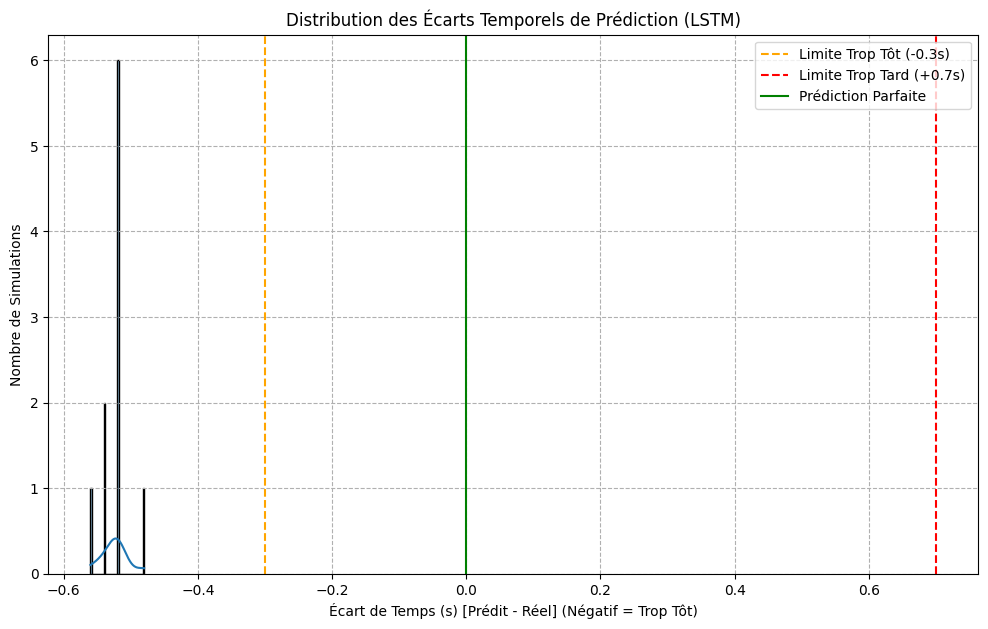


Statistiques sur les Écarts Temporels (LSTM) :
  Nombre total de simulations avec 2e clic analysées: 10
  Moyenne de l'écart: -0.524 s
  Médiane de l'écart: -0.520 s
  Écart-type de l'écart: 0.020 s
  Min écart: -0.560 s (Prédiction la plus précoce par rapport au réel)
  Max écart: -0.480 s (Prédiction la plus tardive par rapport au réel)

Catégorisation des Prédictions (LSTM) :
  Hit: 0 (0.0%)
  Early: 10 (100.0%)
  Late: 0 (0.0%)
  Missed_event: 0 (0.0%)


In [5]:
# Bloc 5: Analyse des Erreurs de Prédiction
# Ce bloc suppose que les imports et certaines fonctions utilitaires (comme get_second_click_time)
# ont été définis dans des blocs précédents si exécuté dans un notebook.
# Pour l'autonomie, je vais réinclure les imports et fonctions nécessaires ici.

# --- Paramètres pour l'Analyse des Erreurs (doivent être cohérents avec l'entraînement) ---
WINDOW_SIZE = 150  # Doit correspondre au WINDOW_SIZE de l'entraînement du modèle à analyser
PREDICTION_HORIZON = 25 # Utilisé par create_sequences_and_labels_for_file pour le mapping
FEATURES_TO_USE = [
    'Acc_X_Raw (m/s^2)', 'Acc_Y_Raw (m/s^2)', 'Acc_Z_Raw (m/s^2)',
    'Gyro_X (rad/s)', 'Gyro_Y (rad/s)', 'Gyro_Z (rad/s)',
    'Force_Cable1 (N)', 'Force_Cable2 (N)',
    'Vel_X_Noisy (m/s)', 'Vel_Y_Noisy (m/s)', 'Vel_Z_Noisy (m/s)',
    'Angle_Pitch_Noisy (rad)', 'Angle_Yaw_Noisy (rad)'
]
SAMPLING_RATE = 50
DT = 1.0 / SAMPLING_RATE

BASE_MODEL_FILENAME = "deblocage_model" # Assurez-vous que c'est le même nom de base
BASE_SCALER_FILENAME = "scaler"      # que celui utilisé lors de la sauvegarde

# Répertoire contenant les données de "training" qui serviront de test pour cette analyse
TRAINING_DATA_DIR_FOR_ANALYSIS = "training_dataset"

# Critères pour identifier une prédiction de déblocage par le modèle
PREDICTION_THRESHOLD_ANALYSIS = 0.7
PERSISTENCE_STEPS_ANALYSIS = int(0.1 * SAMPLING_RATE) # ex: 0.1s

# Fenêtres de tolérance pour catégoriser les prédictions
TOLERANCE_EARLY_S_ANALYSIS = 0.3
TOLERANCE_LATE_S_ANALYSIS = 0.7
MAX_ACCEPTABLE_DELAY_S_ANALYSIS = 2.0

# --- Fonctions Utilitaires (récupérées ou adaptées) ---
DEBUG_FILE_COUNT_LOAD_PROCESS_ANALYSIS = 0 # Compteur de débogage spécifique à cette fonction
MAX_DEBUG_FILES_LOAD_PROCESS_ANALYSIS = 2

def get_second_click_time_analysis(button_states, sampling_rate_local):
    # Identique à la fonction get_second_click_time du script principal
    clicks_start_indices = np.where(np.diff(button_states.astype(int)) == 1)[0] + 1
    if len(button_states) > 0 and button_states[0] == 1:
        if not (len(clicks_start_indices) > 0 and clicks_start_indices[0] == 0):
             clicks_start_indices = np.insert(clicks_start_indices, 0, 0)
        elif not np.any(clicks_start_indices == 0): # S'assurer de ne pas dupliquer si déjà présent
             clicks_start_indices = np.insert(clicks_start_indices, 0, 0)
    if len(clicks_start_indices) >= 2:
        return clicks_start_indices[1], clicks_start_indices[1] / sampling_rate_local
    return None, None

def create_sequences_and_labels_for_file_analysis(df, window_size, prediction_horizon, features, mode="training", sampling_rate_local=50, filename_for_debug="Unknown"):
    # Identique à la fonction create_sequences_and_labels_for_file du script principal
    # mais on utilise un compteur de debug séparé pour ne pas interférer
    global DEBUG_FILE_COUNT_LOAD_PROCESS_ANALYSIS
    X, y = [], [] # y ne sera pas utilisé pour l'analyse de timing directement, mais la fonction le retourne
    raw_button_state = df['Button_State'].values.astype(int)
    actual_second_click_idx, actual_second_click_time = None, None

    if DEBUG_FILE_COUNT_LOAD_PROCESS_ANALYSIS < MAX_DEBUG_FILES_LOAD_PROCESS_ANALYSIS and mode == "training":
        print(f"\n[Debug create_sequences_analysis] Fichier: {filename_for_debug}, Mode: {mode}")
        s_idx_dbg, s_time_dbg = get_second_click_time_analysis(raw_button_state, sampling_rate_local)
        if s_idx_dbg is not None: print(f"[Debug create_sequences_analysis] 2e clic trouvé à l'index {s_idx_dbg} (temps {s_time_dbg:.2f}s)")
        else: print(f"[Debug create_sequences_analysis] PAS de 2e clic trouvé.")

    if mode == "training": # On a besoin du temps du 2e clic pour l'analyse
        actual_second_click_idx, actual_second_click_time = get_second_click_time_analysis(raw_button_state, sampling_rate_local)
        if actual_second_click_idx is None and DEBUG_FILE_COUNT_LOAD_PROCESS_ANALYSIS < MAX_DEBUG_FILES_LOAD_PROCESS_ANALYSIS:
            print(f"Avertissement [Fichier: {filename_for_debug}]: Aucun 2e clic pour étiquetage (analyse).")

    data_for_sequences = df[features].copy()
    positive_labels_found_in_file = 0 # Juste pour le debug
    for i in range(len(data_for_sequences) - window_size - prediction_horizon + 1):
        input_seq = data_for_sequences.iloc[i : i + window_size].values
        label = 0 # L'étiquette réelle de la fenêtre n'est pas le focus principal de cette analyse de timing
        if mode == "training" and actual_second_click_idx is not None:
            start_predict_window_idx = i + window_size
            end_predict_window_idx = i + window_size + prediction_horizon
            if start_predict_window_idx <= actual_second_click_idx < end_predict_window_idx:
                label = 1
                positive_labels_found_in_file +=1
        X.append(input_seq)
        y.append(label) # On retourne y pour la cohérence, mais on utilisera surtout actual_second_click_time

    if DEBUG_FILE_COUNT_LOAD_PROCESS_ANALYSIS < MAX_DEBUG_FILES_LOAD_PROCESS_ANALYSIS and mode == "training":
        print(f"[Debug create_sequences_analysis] Fichier {filename_for_debug}: {positive_labels_found_in_file} étiquettes positives (1) théoriques créées.")
        DEBUG_FILE_COUNT_LOAD_PROCESS_ANALYSIS += 1
    return np.array(X), np.array(y), actual_second_click_time


def load_data_for_error_analysis(main_directory, window_size, prediction_horizon, features, sampling_rate_local=50, scaler_obj=None):
    # Similaire à load_process_all_simulations mais adapté pour l'analyse
    all_X_scaled_for_file = {} # Dictionnaire pour stocker X par fichier
    all_mapping_info_for_file = {} # Dictionnaire pour stocker les infos de mapping par fichier

    print(f"\nAnalyse du répertoire (pour erreurs): {os.path.abspath(main_directory)}")
    if not os.path.isdir(main_directory):
        print(f"Erreur : Le répertoire '{main_directory}' n'existe pas."); return {}, {}

    # On cible les fichiers _training car ils ont le 2e clic
    simulation_files = [f for f in os.listdir(main_directory)
                        if (f.endswith('_training.xlsx') or (f.endswith('.xlsx') and 'inference' not in f.lower() and 'full_for_plot' not in f.lower()))
                        and os.path.isfile(os.path.join(main_directory, f))]

    print(f"Fichiers trouvés pour l'analyse d'erreur: {simulation_files if simulation_files else 'Aucun'}")
    if not simulation_files: return {}, {}

    file_count = 0
    for filename in simulation_files:
        filepath = os.path.join(main_directory, filename)
        current_file_X_list = []
        current_file_mapping_list = []
        try:
            df = pd.read_excel(filepath)
            file_count += 1
            if not all(feat in df.columns for feat in features):
                print(f"Avertissement: Caractéristiques manquantes dans {filename}. Ignoré."); continue
            if 'Button_State' not in df.columns:
                print(f"Avertissement: 'Button_State' manquant dans {filename}. Ignoré."); continue

            # On utilise create_sequences_and_labels_for_file_analysis pour obtenir le temps du clic réel
            # Les étiquettes y_file ne sont pas primordiales ici, mais X_file et second_click_time_file le sont.
            X_file, _, second_click_time_file = create_sequences_and_labels_for_file_analysis(
                df, window_size, prediction_horizon, features, "training", sampling_rate_local, filename_for_debug=filename)

            if X_file.shape[0] > 0:
                # Normaliser X_file avec le scaler fourni
                if scaler_obj:
                    num_s, num_ts, num_f = X_file.shape
                    X_file_reshaped = X_file.reshape(-1, num_f)
                    X_file_scaled_reshaped = scaler_obj.transform(X_file_reshaped)
                    X_file_scaled = X_file_scaled_reshaped.reshape(num_s, num_ts, num_f)
                    all_X_scaled_for_file[filename] = X_file_scaled
                else:
                    print(f"Avertissement: Scaler non fourni pour {filename}. Les données ne seront pas normalisées.")
                    all_X_scaled_for_file[filename] = X_file # Utiliser non normalisé si pas de scaler

                # Stocker les infos de mapping pour ce fichier
                for seq_idx in range(X_file.shape[0]):
                    current_file_mapping_list.append({
                        "filename": filename,
                        "sequence_index_in_file": seq_idx,
                        "prediction_window_start_time": (seq_idx + window_size) / sampling_rate_local,
                        "actual_second_click_time": second_click_time_file
                    })
                all_mapping_info_for_file[filename] = current_file_mapping_list
            else:
                print(f"Aucune séquence générée pour {filename}")

        except Exception as e: print(f"Erreur traitant {filename} pour l'analyse: {e}")

    print(f"{file_count} fichiers traités pour l'analyse des erreurs.")
    return all_X_scaled_for_file, all_mapping_info_for_file


def find_predicted_deblocage_event_time_analysis(probabilities, window_start_times, threshold, persistence_steps):
    if probabilities is None or len(probabilities) < persistence_steps: return None
    for i in range(len(probabilities) - persistence_steps + 1):
        if np.all(probabilities[i : i + persistence_steps] > threshold):
            return window_start_times[i]
    return None

# --- Début du Script d'Analyse des Erreurs ---
print("\n--- DÉBUT DE L'ANALYSE DES ERREURS DE PRÉDICTION ---")

# Demander quel modèle analyser
model_type_to_analyze_errors = ""
while model_type_to_analyze_errors not in ["lstm", "cnn-lstm"]:
    model_type_to_analyze_errors = input("Quel type de modèle entraîné souhaitez-vous analyser pour les erreurs ('lstm' ou 'cnn-lstm') ? ").lower()
print(f"Choix pour l'analyse des erreurs : Modèle {model_type_to_analyze_errors.upper()}")

model_filepath_for_errors = f"{BASE_MODEL_FILENAME}_{model_type_to_analyze_errors}.h5"
scaler_filepath_for_errors = f"{BASE_SCALER_FILENAME}_{model_type_to_analyze_errors}.joblib"

if not (os.path.exists(model_filepath_for_errors) and os.path.exists(scaler_filepath_for_errors)):
    print(f"Modèle ({model_filepath_for_errors}) ou Scaler ({scaler_filepath_for_errors}) non trouvé.")
    print("Assurez-vous d'avoir entraîné ce type de modèle et que les fichiers sont présents.")
else:
    model_for_error_analysis = load_model(model_filepath_for_errors)
    scaler_for_error_analysis = joblib.load(scaler_filepath_for_errors)
    print(f"Modèle et scaler chargés pour l'analyse des erreurs ({model_type_to_analyze_errors}).")

    # Réinitialiser le compteur de debug avant de charger les données pour l'analyse
    DEBUG_FILE_COUNT_LOAD_PROCESS_ANALYSIS = 0

    # Charger les données de test (qui sont les données d'entraînement car elles ont le 2e clic)
    # La fonction retourne un dictionnaire de DataFrames X normalisés, et un dictionnaire de mappings
    dict_X_test_analysis, dict_mapping_info_analysis = load_data_for_error_analysis(
        TRAINING_DATA_DIR_FOR_ANALYSIS,
        window_size=WINDOW_SIZE, # Utiliser WINDOW_SIZE défini globalement (150)
        prediction_horizon=PREDICTION_HORIZON, # Nécessaire pour create_sequences...
        features=FEATURES_TO_USE,
        sampling_rate_local=SAMPLING_RATE,
        scaler_obj=scaler_for_error_analysis # Utiliser le scaler déjà fitté
    )

    if dict_X_test_analysis:
        print(f"\nDonnées de {len(dict_X_test_analysis)} fichiers chargées pour l'analyse des erreurs.")

        time_differences_list = []
        prediction_categories_dict = {"hit": 0, "early": 0, "late": 0, "missed_event": 0, "no_true_event_in_file": 0}

        for filename, X_file_scaled in dict_X_test_analysis.items():
            if X_file_scaled.shape[0] == 0:
                continue

            file_mapping_info = dict_mapping_info_analysis.get(filename, [])
            if not file_mapping_info:
                print(f"Pas d'info de mapping pour {filename}, impossible de trouver le temps de clic réel.")
                prediction_categories_dict["no_true_event_in_file"] += 1
                continue

            # Le temps de clic réel est le même pour toutes les séquences d'un même fichier
            actual_click_time_for_file = file_mapping_info[0]["actual_second_click_time"]

            if actual_click_time_for_file is None:
                prediction_categories_dict["no_true_event_in_file"] += 1
                continue

            probabilities_file = model_for_error_analysis.predict(X_file_scaled).flatten()

            # Les temps de début de fenêtre de prédiction pour ce fichier
            file_prediction_window_start_times = [m["prediction_window_start_time"] for m in file_mapping_info]

            predicted_time = find_predicted_deblocage_event_time_analysis(
                probabilities_file, file_prediction_window_start_times,
                PREDICTION_THRESHOLD_ANALYSIS, PERSISTENCE_STEPS_ANALYSIS
            )

            if predicted_time is not None:
                diff = predicted_time - actual_click_time_for_file
                time_differences_list.append(diff)
                if diff < (-TOLERANCE_EARLY_S_ANALYSIS): prediction_categories_dict["early"] += 1
                elif diff > TOLERANCE_LATE_S_ANALYSIS:
                    if diff <= MAX_ACCEPTABLE_DELAY_S_ANALYSIS: prediction_categories_dict["late"] += 1
                    else: prediction_categories_dict["missed_event"] +=1
                else: prediction_categories_dict["hit"] += 1
            else:
                prediction_categories_dict["missed_event"] += 1

        if time_differences_list:
            time_differences_array = np.array(time_differences_list)
            plt.figure(figsize=(12, 7))
            sns.histplot(time_differences_array, kde=True, bins=40)
            plt.title(f"Distribution des Écarts Temporels de Prédiction ({model_type_to_analyze_errors.upper()})")
            plt.xlabel("Écart de Temps (s) [Prédit - Réel] (Négatif = Trop Tôt)")
            plt.ylabel("Nombre de Simulations")
            plt.grid(True, linestyle='--')
            plt.axvline(-TOLERANCE_EARLY_S_ANALYSIS, color='orange', linestyle='--', label=f'Limite Trop Tôt (-{TOLERANCE_EARLY_S_ANALYSIS}s)')
            plt.axvline(TOLERANCE_LATE_S_ANALYSIS, color='red', linestyle='--', label=f'Limite Trop Tard (+{TOLERANCE_LATE_S_ANALYSIS}s)')
            plt.axvline(0, color='green', linestyle='-', label='Prédiction Parfaite')
            plt.legend()
            plt.show()

            print(f"\nStatistiques sur les Écarts Temporels ({model_type_to_analyze_errors.upper()}) :")
            print(f"  Nombre total de simulations avec 2e clic analysées: {len(time_differences_array)}")
            print(f"  Moyenne de l'écart: {np.mean(time_differences_array):.3f} s")
            print(f"  Médiane de l'écart: {np.median(time_differences_array):.3f} s")
            print(f"  Écart-type de l'écart: {np.std(time_differences_array):.3f} s")
            print(f"  Min écart: {np.min(time_differences_array):.3f} s (Prédiction la plus précoce par rapport au réel)")
            print(f"  Max écart: {np.max(time_differences_array):.3f} s (Prédiction la plus tardive par rapport au réel)")

            print(f"\nCatégorisation des Prédictions ({model_type_to_analyze_errors.upper()}) :")
            total_evaluated_events_for_cat = sum(prediction_categories_dict[k] for k in ["hit", "early", "late", "missed_event"])
            if total_evaluated_events_for_cat > 0:
                for cat, count in prediction_categories_dict.items():
                    if cat != "no_true_event_in_file":
                        print(f"  {cat.capitalize()}: {count} ({count/total_evaluated_events_for_cat*100:.1f}%)")
            if prediction_categories_dict["no_true_event_in_file"] > 0:
                print(f"  Fichiers sans 2e clic réel (non analysés pour le timing): {prediction_categories_dict['no_true_event_in_file']}")
        else:
            print("Aucun écart temporel n'a pu être calculé. Cela peut arriver si aucun événement n'a été prédit ou si aucun fichier de test ne contenait de 2e clic.")
    else:
        print(f"Aucune donnée de test n'a pu être chargée depuis {TRAINING_DATA_DIR_FOR_ANALYSIS} pour l'analyse des erreurs.")




--- COMPARAISON DES MODÈLES ENTRAÎNÉS ---

Évaluation du modèle : LSTM


Modèle et scaler LSTM chargés.
Chargement des données pour comparaison depuis : c:\Users\Gabriel Franco\Informatique\Exosquelette\training_dataset
Utilisation des 10 premiers fichiers pour la comparaison.
Ensemble de données de comparaison préparé: X_shape=(937, 150, 13), y_shape=(937,)

--- Métriques de Classification pour LSTM (sur fenêtres de l'ensemble de comparaison) ---
  Distribution y_eval_comp: [862  75]
  Précision Globale (Accuracy): 0.9893
  Précision (Classe 1 - Clic): 0.8916
  Rappel (Classe 1 - Clic): 0.9867
  Score F1 (Classe 1 - Clic): 0.9367

--- Temps d'Inférence pour LSTM ---
  Temps moyen pour traiter 937 échantillons: 1.4624 s (sur 10 répétitions)
  Temps d'inférence moyen par échantillon (fenêtre): 1.5607 ms

Évaluation du modèle : CNN-LSTM
Modèle ou scaler pour cnn-lstm non trouvé à 'deblocage_model_cnn-lstm.h5' ou 'scaler_cnn-lstm.joblib'. Passe à suivant.


--- RÉSUMÉ DE LA COMPARAISON DES MODÈLES ---
          accuracy  precision_class1  recall_class1  f1_sco

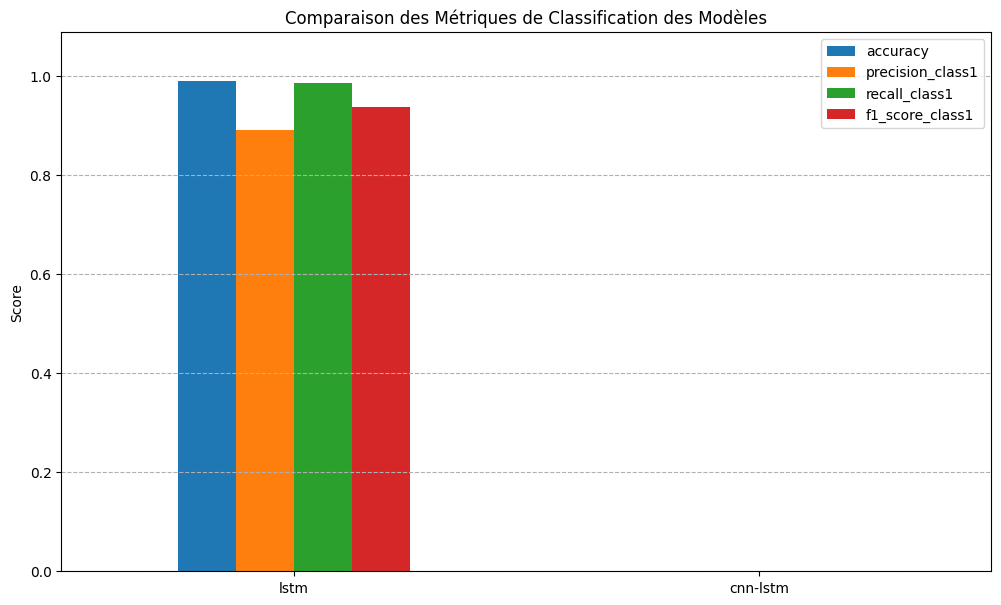

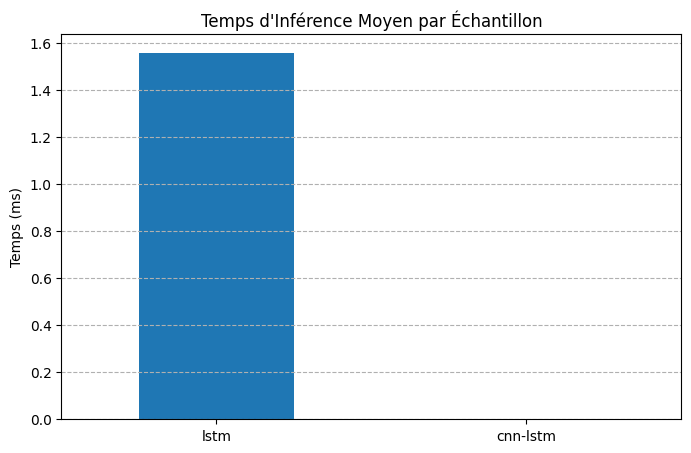

In [6]:
# --- Paramètres Globaux (Rappel, doivent être cohérents) ---
import time # Ajouter l'import de time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score # Ajouter l'import de precision_recall_fscore_support et accuracy_score

WINDOW_SIZE_COMP = 150
FEATURES_TO_USE_COMP = [
    'Acc_X_Raw (m/s^2)', 'Acc_Y_Raw (m/s^2)', 'Acc_Z_Raw (m/s^2)',
    'Gyro_X (rad/s)', 'Gyro_Y (rad/s)', 'Gyro_Z (rad/s)',
    'Force_Cable1 (N)', 'Force_Cable2 (N)',
    'Vel_X_Noisy (m/s)', 'Vel_Y_Noisy (m/s)', 'Vel_Z_Noisy (m/s)',
    'Angle_Pitch_Noisy (rad)', 'Angle_Yaw_Noisy (rad)'
]
SAMPLING_RATE_COMP = 50
PREDICTION_HORIZON_COMP = 25 # Important pour la fonction create_sequences...

# Chemins de base (les noms de fichiers seront complétés par _lstm ou _cnn-lstm)
BASE_MODEL_FILENAME_COMP = "deblocage_model"
BASE_SCALER_FILENAME_COMP = "scaler"
# Utiliser le même répertoire de données d'entraînement pour charger un ensemble de test/validation cohérent
DATA_DIR_FOR_COMP = "training_dataset"

# Nombre de répétitions pour mesurer le temps d'inférence
N_INFERENCE_REPEATS = 10
INFERENCE_BATCH_SIZE = 256 # Taille de batch pour l'inférence

# --- Fonctions Utilitaires (simplifiées pour le chargement de données de test) ---
def get_second_click_time_comp(button_states, sampling_rate_local):
    clicks_start_indices = np.where(np.diff(button_states.astype(int)) == 1)[0] + 1
    if len(button_states) > 0 and button_states[0] == 1:
        if not (len(clicks_start_indices) > 0 and clicks_start_indices[0] == 0):
             clicks_start_indices = np.insert(clicks_start_indices, 0, 0)
        elif not np.any(clicks_start_indices == 0):
             clicks_start_indices = np.insert(clicks_start_indices, 0, 0)
    if len(clicks_start_indices) >= 2:
        return clicks_start_indices[1], clicks_start_indices[1] / sampling_rate_local
    return None, None

def create_sequences_and_labels_for_file_comp(df, window_size, prediction_horizon, features, sampling_rate_local=50):
    X, y = [], []
    raw_button_state = df['Button_State'].values.astype(int)
    actual_second_click_idx, _ = get_second_click_time_comp(raw_button_state, sampling_rate_local)

    data_for_sequences = df[features].copy()
    for i in range(len(data_for_sequences) - window_size - prediction_horizon + 1):
        input_seq = data_for_sequences.iloc[i : i + window_size].values
        label = 0
        if actual_second_click_idx is not None:
            start_predict_window_idx = i + window_size
            end_predict_window_idx = i + window_size + prediction_horizon
            if start_predict_window_idx <= actual_second_click_idx < end_predict_window_idx:
                label = 1
        X.append(input_seq)
        y.append(label)
    return np.array(X), np.array(y)

def load_and_prepare_data_for_comparison(main_directory, window_size, prediction_horizon, features, sampling_rate_local, scaler_to_use):
    all_X_comp, all_y_comp = [], []
    print(f"Chargement des données pour comparaison depuis : {os.path.abspath(main_directory)}")

    simulation_files = [f for f in os.listdir(main_directory)
                        if (f.endswith('_training.xlsx') or (f.endswith('.xlsx') and 'inference' not in f.lower() and 'full_for_plot' not in f.lower()))
                        and os.path.isfile(os.path.join(main_directory, f))]

    if not simulation_files:
        print("Aucun fichier de données trouvé pour la comparaison.")
        return np.array([]), np.array([])

    # Pour être plus robuste, on pourrait prendre un nombre fixe de fichiers ou de séquences
    # ou s'assurer que X_val/y_val de l'entraînement sont passés à cette fonction.
    # Ici, on recharge tout et on resplitte, ce qui est ok pour une comparaison mais peut être long.
    # On va limiter aux 50 premiers fichiers pour la comparaison pour que ce soit plus rapide.
    print(f"Utilisation des {min(len(simulation_files), 50)} premiers fichiers pour la comparaison.")
    files_to_load_for_comp = simulation_files[:min(len(simulation_files), 50)]


    for filename in files_to_load_for_comp:
        filepath = os.path.join(main_directory, filename)
        try:
            df = pd.read_excel(filepath)
            if not all(feat in df.columns for feat in features) or 'Button_State' not in df.columns:
                print(f"Avertissement: Colonnes manquantes dans {filename} pour la comparaison. Ignoré.")
                continue
            X_file, y_file = create_sequences_and_labels_for_file_comp(df, window_size, prediction_horizon, features, sampling_rate_local)
            if X_file.shape[0] > 0:
                all_X_comp.append(X_file)
                all_y_comp.append(y_file)
        except Exception as e: print(f"Erreur chargement {filename} pour comparaison: {e}")

    if not all_X_comp:
        print("Aucune séquence chargée pour la comparaison.")
        return np.array([]), np.array([])

    X_combined = np.concatenate(all_X_comp, axis=0)
    y_combined = np.concatenate(all_y_comp, axis=0)

    if X_combined.shape[0] == 0:
        print("X_combined est vide après concaténation pour la comparaison.")
        return np.array([]), np.array([])

    num_samples, num_timesteps, num_features = X_combined.shape
    X_reshaped = X_combined.reshape(-1, num_features)

    if scaler_to_use is None:
        print("Erreur: Scaler non fourni pour la préparation des données de comparaison.")
        return np.array([]), np.array([])

    X_scaled_reshaped = scaler_to_use.transform(X_reshaped)
    X_scaled = X_scaled_reshaped.reshape(num_samples, num_timesteps, num_features)

    # Utiliser un split fixe pour la reproductibilité de la comparaison
    # Si y_combined a des classes, stratifier.
    if len(np.unique(y_combined)) > 1:
        _, X_test_comp, _, y_test_comp = train_test_split(X_scaled, y_combined, test_size=0.3, shuffle=True, stratify=y_combined, random_state=42)
    else:
        _, X_test_comp, _, y_test_comp = train_test_split(X_scaled, y_combined, test_size=0.3, shuffle=True, random_state=42)

    print(f"Ensemble de données de comparaison préparé: X_shape={X_test_comp.shape}, y_shape={y_test_comp.shape}")
    if X_test_comp.shape[0] == 0:
        print("L'ensemble de test pour la comparaison est vide.")
    return X_test_comp, y_test_comp

# --- Script Principal de Comparaison ---
print("\n--- COMPARAISON DES MODÈLES ENTRAÎNÉS ---")

model_types_to_compare = ["lstm", "cnn-lstm"]
comparison_results = {}

# Charger un ensemble de données commun pour l'évaluation
# On a besoin d'un scaler pour cela. On va prendre le scaler du premier modèle qui existe.
# Idéalement, les données devraient être préparées une seule fois avec un scaler "universel"
# ou chaque modèle est testé sur des données normalisées avec SON PROPRE scaler.
# Pour cette comparaison, nous allons normaliser les données avec le scaler de chaque modèle respectif.

for model_type in model_types_to_compare:
    print(f"\nÉvaluation du modèle : {model_type.upper()}")
    model_filepath_comp = f"{BASE_MODEL_FILENAME_COMP}_{model_type}.h5"
    scaler_filepath_comp = f"{BASE_SCALER_FILENAME_COMP}_{model_type}.joblib"

    if not (os.path.exists(model_filepath_comp) and os.path.exists(scaler_filepath_comp)):
        print(f"Modèle ou scaler pour {model_type} non trouvé à '{model_filepath_comp}' ou '{scaler_filepath_comp}'. Passe à suivant.")
        comparison_results[model_type] = {"error": "Fichiers modèle/scaler non trouvés"}
        continue

    try:
        model_comp = load_model(model_filepath_comp)
        scaler_comp = joblib.load(scaler_filepath_comp)
        print(f"Modèle et scaler {model_type.upper()} chargés.")
    except Exception as e:
        print(f"Erreur lors du chargement du modèle ou du scaler pour {model_type}: {e}")
        comparison_results[model_type] = {"error": f"Erreur chargement: {e}"}
        continue

    X_eval_comp, y_eval_comp = load_and_prepare_data_for_comparison(
        DATA_DIR_FOR_COMP, WINDOW_SIZE_COMP, PREDICTION_HORIZON_COMP,
        FEATURES_TO_USE_COMP, SAMPLING_RATE_COMP, scaler_comp # Utiliser le scaler du modèle actuel
    )

    if X_eval_comp.shape[0] == 0 or y_eval_comp.shape[0] == 0:
        print(f"Aucune donnée d'évaluation pour {model_type} après chargement/préparation. Passe à suivant.")
        comparison_results[model_type] = {"error": "Aucune donnée d'évaluation préparée"}
        continue

    # 1. Métriques de Classification
    y_pred_proba_comp = model_comp.predict(X_eval_comp, batch_size=INFERENCE_BATCH_SIZE, verbose=0)
    y_pred_comp = (y_pred_proba_comp > 0.5).astype(int).flatten()

    accuracy = accuracy_score(y_eval_comp, y_pred_comp)
    # average='binary' suppose que la classe positive est 1.
    # Si y_eval_comp ne contient que des 0, precision/recall/f1 pour la classe 1 seront 0.
    if 1 not in y_eval_comp and 1 not in y_pred_comp: # Si aucun positif ni prédit ni réel
        precision, recall, f1 = 0.0, 0.0, 0.0
    elif 1 not in y_eval_comp: # Si aucun positif réel, mais potentiellement prédit
        precision, recall, f1 = 0.0, 0.0, 0.0 # Recall est 0, Precision peut être 0 si FP > 0
    else: # Il y a des positifs réels
        precision, recall, f1, _ = precision_recall_fscore_support(y_eval_comp, y_pred_comp, average='binary', pos_label=1, zero_division=0)

    print(f"\n--- Métriques de Classification pour {model_type.upper()} (sur fenêtres de l'ensemble de comparaison) ---")
    print(f"  Distribution y_eval_comp: {np.bincount(y_eval_comp.astype(int))}")
    print(f"  Précision Globale (Accuracy): {accuracy:.4f}")
    print(f"  Précision (Classe 1 - Clic): {precision:.4f}")
    print(f"  Rappel (Classe 1 - Clic): {recall:.4f}")
    print(f"  Score F1 (Classe 1 - Clic): {f1:.4f}")

    # 2. Temps d'Inférence Moyen
    inference_times = []
    if X_eval_comp.shape[0] >= INFERENCE_BATCH_SIZE : # S'assurer qu'on a au moins un batch pour l'échauffement
        _ = model_comp.predict(X_eval_comp[:INFERENCE_BATCH_SIZE], batch_size=INFERENCE_BATCH_SIZE, verbose=0)

    num_samples_for_timing = X_eval_comp.shape[0]
    if num_samples_for_timing == 0:
        avg_inference_time_per_sample = float('nan')
        print(f"\n--- Temps d'Inférence pour {model_type.upper()} ---")
        print(f"  Pas assez de données pour mesurer le temps d'inférence.")
    else:
        for _ in range(N_INFERENCE_REPEATS):
            start_time = time.time()
            _ = model_comp.predict(X_eval_comp, batch_size=INFERENCE_BATCH_SIZE, verbose=0)
            end_time = time.time()
            inference_times.append(end_time - start_time)

        avg_inference_time_total_run = np.mean(inference_times)
        avg_inference_time_per_sample = (avg_inference_time_total_run / num_samples_for_timing) * 1000 # en ms

        print(f"\n--- Temps d'Inférence pour {model_type.upper()} ---")
        print(f"  Temps moyen pour traiter {num_samples_for_timing} échantillons: {avg_inference_time_total_run:.4f} s (sur {N_INFERENCE_REPEATS} répétitions)")
        print(f"  Temps d'inférence moyen par échantillon (fenêtre): {avg_inference_time_per_sample:.4f} ms")

    comparison_results[model_type] = {
        "accuracy": accuracy,
        "precision_class1": precision,
        "recall_class1": recall,
        "f1_score_class1": f1,
        "avg_inference_time_ms_per_sample": avg_inference_time_per_sample
    }

# --- Affichage des Résultats de Comparaison ---
print("\n\n--- RÉSUMÉ DE LA COMPARAISON DES MODÈLES ---")
results_df = pd.DataFrame.from_dict(comparison_results, orient='index')
print(results_df.to_string()) # .to_string() pour un meilleur affichage dans les logs

if not results_df.empty:
    metrics_to_plot = ['accuracy', 'precision_class1', 'recall_class1', 'f1_score_class1']
    plot_df = results_df[metrics_to_plot].copy()
    for col in metrics_to_plot: plot_df[col] = pd.to_numeric(plot_df[col], errors='coerce')

    if not plot_df.dropna().empty:
        plot_df.plot(kind='bar', figsize=(12, 7), rot=0)
        plt.title("Comparaison des Métriques de Classification des Modèles"); plt.ylabel("Score")
        plt.ylim(0, max(1.05, plot_df[metrics_to_plot].max().max() * 1.1 if not plot_df.empty else 1.05) ); plt.grid(axis='y', linestyle='--'); plt.show()
    else:
        print("Aucune donnée numérique valide à plotter pour les métriques de classification.")

    if 'avg_inference_time_ms_per_sample' in results_df.columns:
        time_plot_df = results_df[['avg_inference_time_ms_per_sample']].copy()
        time_plot_df['avg_inference_time_ms_per_sample'] = pd.to_numeric(time_plot_df['avg_inference_time_ms_per_sample'], errors='coerce')

        if not time_plot_df.dropna().empty:
            time_plot_df.plot(kind='bar', figsize=(8, 5), rot=0, legend=False)
            plt.title("Temps d'Inférence Moyen par Échantillon"); plt.ylabel("Temps (ms)")
            plt.grid(axis='y', linestyle='--'); plt.show()
        else:
            print("Pas de données valides de temps d'inférence à plotter.")
else:
    print("Aucun résultat de comparaison à afficher.")
